# AM 231: Final Report

## Experimental Design

We work with two canonical image datasets, both of which relate to multi-class prediction (classification) problems: 

1. The MNIST dataset (from openml). Each of the 10,000 samples is a 28 x 28 grayscale image corresponding to one of ten digits. We also generate six additional datasets from this original set:

    **a.** The 50% Masked MNIST dataset. For each sample in the original dataset, this set contains a corresponding corrupted sample. That is, each sample has had its rank truncated to rank 5, and each pixel of the resulting rank-truncated image has been masked (mapped to 0) with probability 0.5.

    **b.** The Interpolated 50% Masked MNIST dataset. For each sample in the above masked dataset (1a), this set contains a corresponding sample reconstructed through polynomial interpolation. This interpolation (Matlab's griddata function) takes as input the location of each unmasked pixel and the grayscale values associated with each pixel within a sample. 
    
    **c.** The FPC 50% Masked MNIST dataset. For each sample in the above masked dataset (1a), this set contains a corresponding sample reconstructed through FPC. The implementation of FPC used to generate these reconstructions is contained in the file Mnist_processor_50pctmask.m.
    
    **d.** The 80% Masked MNIST dataset. For each sample in the original dataset, this set contains a corresponding corrupted sample. That is, each sample has had its rank truncated to rank 5, and each pixel of the resulting rank-truncated image has been masked (mapped to 0) with probability 0.8.
    
    **e.** The Interpolated 80% Masked MNIST dataset. For each sample in the above masked dataset (1d), this set contains a corresponding sample reconstructed through polynomial interpolation (as in set (1b)). 
    
    **f.** The FPC 80% Masked MNIST dataset. For each sample in the above masked dataset (1d), this set contains a corresponding sample reconstructed through FPC. The implementation of FPC used to generate these reconstructions is contained in the file Mnist_processor_80pctmask.m.


2. The Deep Weeds dataset (from TensorFlow Datasets). Each of the 10,000 samples is a 256 x 256 grayscale image corresponding to one of nine different varieties of weeds. We also generate three additional datasets from this original set (note that while this dataset contains 10,000 samples, practical limits in computing power prevent us from generating more than 1,760 samples in each of the below datasets):

    **a.** The 50% Masked Deep Weeds dataset. For each of the first 1,760 samples in the original dataset, this set contains a corresponding corrupted sample. That is, each sample has had its rank truncated to rank 43, and each pixel of the resulting rank-truncated image has been masked (mapped to 0) with probability 0.5.
    
    **b.** The Interpolated 50% Masked Deep Weeds dataset. For each sample in the above masked dataset (2a), this set contains a corresponding sample reconstructed through polynomial interpolation (as in sets (1b) and (1e)). 
    
    **c.** The FPC 50% Masked Deep Weeds dataset. For each sample in the above masked dataset (2a), this set contains a corresponding sample reconstructed through FPC. The implementation of FPC used to generate these reconstructions is contained in the file weeds_processor_50pctmask.m.

For each of these eleven datasets, we train two ensembles of models for predicting class membership of input images:
1. Logistic Regression (LR). Models are trained on varying amounts of flattened samples, and are evaluated using a withheld test set.


2. Convolutional Neural Networks (CNN). Models are trained on varying amounts of samples, and are evaluated using a withheld test set. Each model contains the following layers, in order:
    - Two 2D convolutional layers, each with ReLU activation functions. For the MNIST datasets, these are 32 filters with a 3 x 3 kernel, and 64 filters with a 3 x 3 kernel, in order. For the Deep Weeds datasets, these are 32 filters with a 16 x 16 kernel and a 8 x 8 stride, and 64 filters with a 8 x 8 kernel and a 2 x 2 stride, in order.
    - A 2D Max Pooling Layer, followed by a dropout function with threshhold 0.25. For the MNIST datasets, the pool size is 2 x 2. For the Deep Weeds datasets, the pool size is 3 x 3.
    - A dense layer with ReLU activation followed by a dropout function with threshhold 0.25. For the MNIST datasets, the ouput size of this layer is 128. For the Deep Weeds datasets, the ouput size of this layer is 256.
    - A final dense layer with softmax activation, where the output size is equal to the number of classes represented in the dataset (10 for the MNIST datasets, 9 for the Deep Weeds datasets).
    
For each model trained, we record the model's training and test accuracies. We define a simple measure of overfitting to be the difference between a model's training accuracy and test accuracy. Generally, as the number of samples $n$ used to train these models increases, the models' test accuracies increase and their training accuracies decrease, such that our overfitting measure approaches an asymptote. We can assess the quality of a corrupted or reconstructed signal (from the perspective of each of the above two signal processing tasks) by examining the asymptotic value of our overfitting measure, as well as the rate at which the measure convergees to that asymptote, and comparing to the measure observed for the models trained on the original MNIST/Deep Weeds datasets. Higher asymptotic measures of overfitting and slower convergence are indicative of higher aleatoric uncertainty (as this uncertainty cannot be reduced though additional training) and higher epistemic uncertainty (as the models require more training samples to converge), respectively.

## Results and Discussion

The code contained in the cells below executes the experiments described above. Additional notebooks and Matlab scripts were used to generate each of the eleven datasets, and should be run before executing the code in this notebook. 

**For the MNIST datasets, first execute all code in MNist_data_gen.ipynb to generate the original dataset, then execute both Mnist_processor_50pctmask.m and Mnist_processor_80pctmask.m (in the file signal_reconstruction) to generate the corresponding corrupted and reconstructed datasets. For the Deep Weeds datasets, first execute all code in deep_weeds_data_gen.ipynb to generate the original dataset, then execute weeds_processor_50pctmask.m (in the file signal_reconstruction) to generate the corresponding corrupted and reconstructed datasets.** 

Throughout this section, we provide discussion of observed results between code blocks.

In [1]:
# Imports
import autograd.numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
%matplotlib inline

### MNIST Datasets

#### Original Dataset

We first generate a baseline overfitting measure for the MNIST datatsets by training our models on the original data.

In [3]:
# Load the MNIST dataset
X_subset = np.array([np.genfromtxt('./MNist_csv_raw/MNIST{}.csv'.format(i),delimiter=',')[1:,1:] for i in range(10000)])
y_subset = np.genfromtxt('./MNist_csv_raw/MNIST_y.csv',delimiter=',')[1:,1:]
y_subset = y_subset.astype(int)
y_subset = y_subset.flatten()
X_subset = X_subset.reshape((X_subset.shape[0], -1))

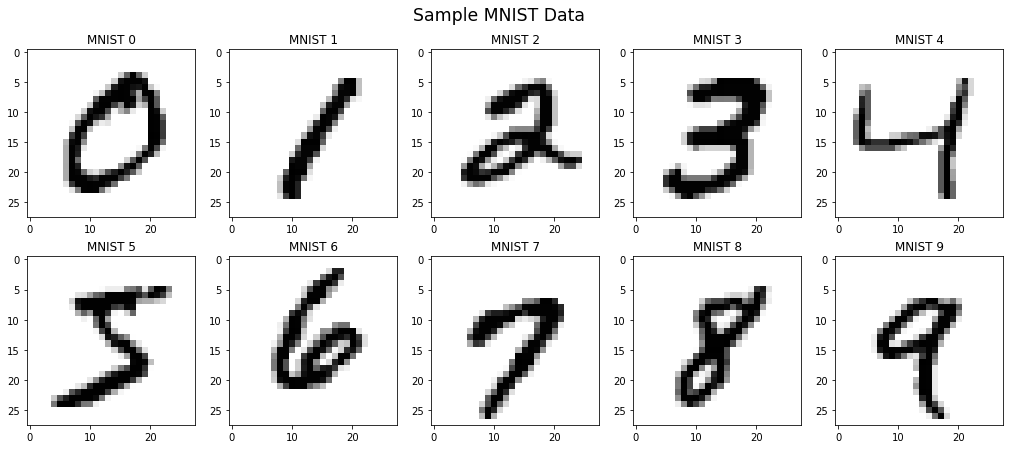

In [4]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 5, figsize=(17.5, 7))
for i in range(5):
    ax[0, i].imshow(X_subset[y_subset == i][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[0,i].set_title(r'MNIST {}'.format(i))
    ax[1, i].imshow(X_subset[y_subset == i+5][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1,i].set_title(r'MNIST {}'.format(i+5))
fig.suptitle(r'Sample MNIST Data',y=0.96,size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [5]:
# Train a single model on 3,000 samples to guage the  asymptotic
# value of our overfitting measure for this dataset/model class 
n_train = 3000

X_train, y_train = X_subset[:n_train], y_subset[:n_train]
X_test, y_test = X_subset[-n_train:], y_subset[-n_train:]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train, y_train)
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our training data.'.format(100*acc_train)))
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our test data.'.format(100*acc_test)))

Our trained classifier correctly classifies 93.73% of our training data.

Our trained classifier correctly classifies 88.47% of our test data.

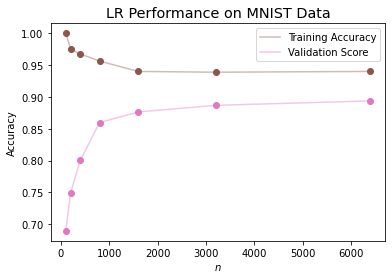

In [56]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains = np.zeros(7)
tests = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset[:n], y_subset[:n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains[i] = model.score(X_tr, y_tr)
    tests[i] = model.score(X_test, y_test)
    
plt.plot(ns,trains,label=r'Training Accuracy', alpha=0.4, color='C5')
plt.scatter(ns,trains,color='C5')
plt.plot(ns,tests,label=r'Validation Score', alpha=0.4, color='C6')
plt.scatter(ns,tests,color='C6')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'LR Performance on MNIST Data',size='x-large')
plt.legend()
plt.show()

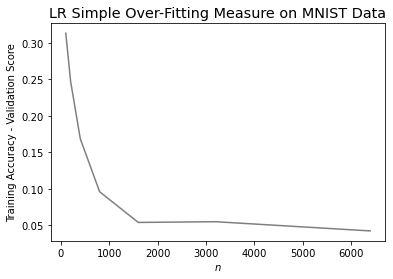

In [55]:
# Plot our simple overfitting measure as a function of n
diffs = trains - tests
plt.plot(ns,diffs,color='C7')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the MNIST dataset converges to an asymptotic value of approximately 0.05 for $n$ greater than (roughly) 1,600. This baseline will inform our discussion of the related corrupted and reconstructed datasets.

##### Convolutional Neural Network (CNN)

In [35]:
# Reshape training data for use in CNN models
X_train_cnn, X_test_cnn = X_train.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1)

y_train_cnn, y_test_cnn = np.zeros((y_train.size, y_train.max()+1)), np.zeros((y_test.size, y_test.max()+1))
y_train_cnn[np.arange(y_train.size),y_train] = 1
y_test_cnn[np.arange(y_test.size) ,y_test] = 1

In [37]:
# Train a single model on 3,000 samples to guage the  asymptotic
# value of our overfitting measure for this dataset/model class 
batch_size = 128
epochs = 10

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_cnn, y_train_cnn, batch_size=batch_size, epochs=epochs, 
                    verbose=0, validation_data=(X_test_cnn, y_test_cnn))

display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our training data.'.format(100*history.history['accuracy'][-1])))
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our test data.'.format(100*history.history['val_accuracy'][-1])))

Our trained classifier correctly classifies 98.77% of our training data.

Our trained classifier correctly classifies 93.97% of our test data.

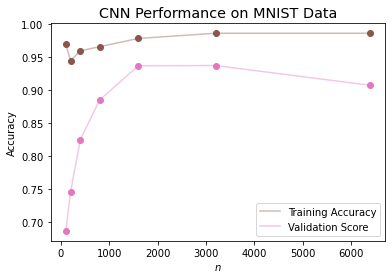

In [42]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_cnn = np.zeros(7)
tests_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_cnn[:n], y_train_cnn[:n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    temp_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(2, 2)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(128, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(10, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_cnn, y_test_cnn))
    trains_cnn[i] = temp_history.history['accuracy'][-1]
    tests_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_cnn,label=r'Training Accuracy', alpha=0.4, color='C5')
plt.scatter(ns,trains_cnn,color='C5')
plt.plot(ns,tests_cnn,label=r'Validation Score', alpha=0.4, color='C6')
plt.scatter(ns,tests_cnn,color='C6')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'CNN Performance on MNIST Data',size='x-large')
plt.legend()
plt.show()

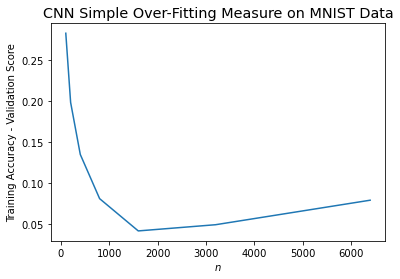

In [63]:
# Plot our simple overfitting measure as a function of n
diffs_cnn = trains_cnn - tests_cnn
plt.plot(ns,diffs_cnn)
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'CNN Simple Over-Fitting Measure on MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the CNN models trained on the MNIST dataset converges to an asymptotic value of approximately 0.06 for $n$ greater than (roughly) 2,000. This baseline will inform our discussion of the related corrupted and reconstructed datasets.

#### 50% Masked Dataset

We now examine the 50% Masked MNIST dataset, and compare to results observed for the original dataset.

In [8]:
# Load the 50% Masked MNIST dataset 
X_subset_masked = np.array([np.genfromtxt('./MNist_csv_50pcentMasked/MNIST{}.csv'.format(i),delimiter=',')
                            for i in range(10000)])
X_subset_masked = X_subset_masked.reshape((X_subset.shape[0], -1))

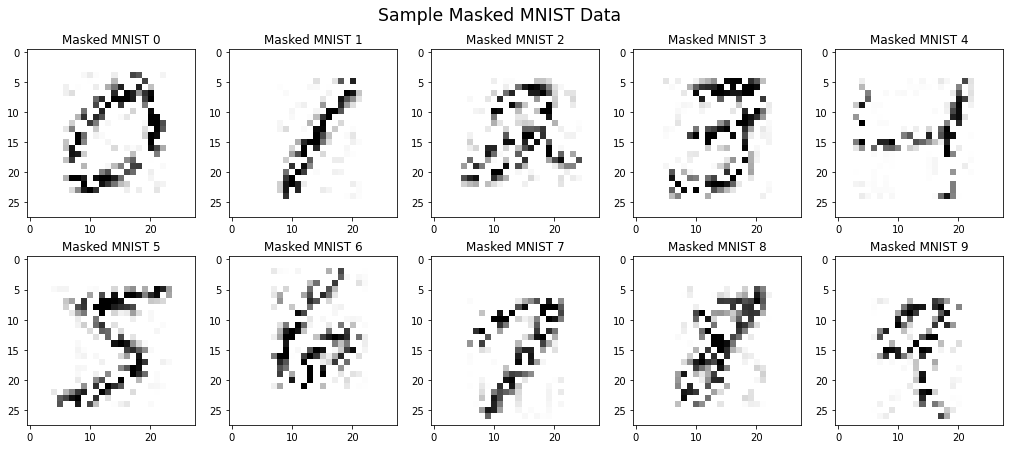

In [9]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 5, figsize=(17.5, 7))
for i in range(5):
    ax[0, i].imshow(X_subset_masked[y_subset == i][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[0,i].set_title(r'Masked MNIST {}'.format(i))
    ax[1, i].imshow(X_subset_masked[y_subset == i+5][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1,i].set_title(r'Masked MNIST {}'.format(i+5))
fig.suptitle(r'Sample Masked MNIST Data',y=0.96,size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [16]:
# Train a single model on 3,000 samples to guage the  asymptotic
# value of our overfitting measure for this dataset/model class 
X_train_masked, X_test_masked = X_subset_masked[:n_train], X_subset_masked[-n_train:]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train_masked, y_train)
acc_train_masked = model.score(X_train_masked, y_train)
acc_test_masked = model.score(X_test_masked, y_test)
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our masked training data.'.format(100*acc_train_masked)))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our masked test data.'.format(100*acc_test_masked)))

Our trained classifier correctly classifies 94.13% of our masked training data.

Our trained classifier correctly classifies 81.00% of our masked test data.

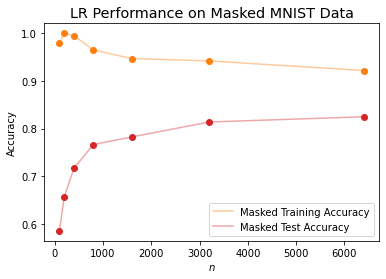

In [54]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_m = np.zeros(7)
tests_m = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset_masked[:n], y_subset[:n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains_m[i] = model.score(X_tr, y_tr)
    tests_m[i] = model.score(X_test_masked, y_test) 
    
plt.plot(ns,trains_m,label=r'Masked Training Accuracy', alpha=0.4, color='C1')
plt.scatter(ns,trains_m,color='C1')
plt.plot(ns,tests_m,label=r'Masked Test Accuracy', alpha=0.4, color='C3')
plt.scatter(ns,tests_m,color='C3')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'LR Performance on Masked MNIST Data',size='x-large')
plt.legend()
plt.show()

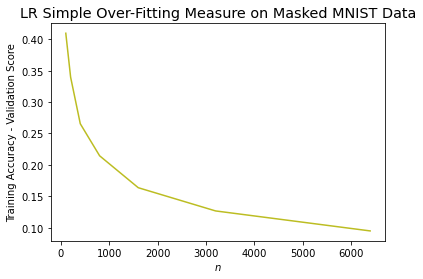

In [53]:
# Plot our simple overfitting measure as a function of n
diffs_m = trains_m - tests_m
plt.plot(ns,diffs_m,color='C8')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the 50% Masked MNIST dataset does not converge to an asymptotic value for $n\le6,400$. This is expected, as this corrupted dataset has higher epistemic uncertainty (as a result of rank truncation) and aleatoric uncertainty (as a result of masking).

##### Convolutional Neural Network (CNN)

In [39]:
# Reshape training data for use in CNN models
X_train_masked_cnn, X_test_masked_cnn = X_train_masked.reshape(-1, 28, 28, 1), X_test_masked.reshape(-1, 28, 28, 1)

In [40]:
# Train a single model on 3,000 samples to guage the  asymptotic
# value of our overfitting measure for this dataset/model class
model_masked = Sequential()

model_masked.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_masked.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_masked.add(MaxPooling2D(pool_size=(2, 2)))
model_masked.add(Dropout(0.25))
model_masked.add(Flatten())
model_masked.add(Dense(128, activation='relu'))
model_masked.add(Dropout(0.25))
model_masked.add(Dense(10, activation='softmax'))

model_masked.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history_masked = model_masked.fit(X_train_masked_cnn, y_train_cnn, batch_size=batch_size, epochs=epochs, 
                                  verbose=0, validation_data=(X_test_masked_cnn, y_test_cnn))

display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our masked training data.'.format(100*history_masked.history['accuracy'][-1])))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our masked test data.'.format(100*history_masked.history['val_accuracy'][-1])))

Our trained classifier correctly classifies 98.10% of our masked training data.

Our trained classifier correctly classifies 89.70% of our masked test data.

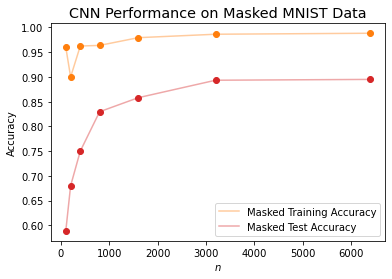

In [41]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_m_cnn = np.zeros(7)
tests_m_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_masked_cnn[:n], y_train_cnn[:n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    temp_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(2, 2)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(128, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(10, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_masked_cnn, y_test_cnn))
    trains_m_cnn[i] = temp_history.history['accuracy'][-1]
    tests_m_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_m_cnn,label=r'Masked Training Accuracy', alpha=0.4, color='C1')
plt.scatter(ns,trains_m_cnn,color='C1')
plt.plot(ns,tests_m_cnn,label=r'Masked Test Accuracy', alpha=0.4, color='C3')
plt.scatter(ns,tests_m_cnn,color='C3')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'CNN Performance on Masked MNIST Data',size='x-large')
plt.legend()
plt.show()

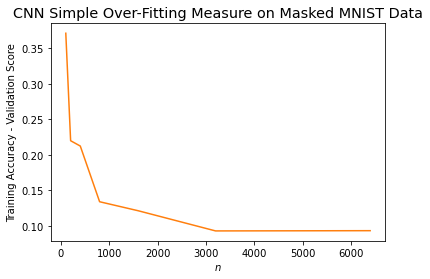

In [64]:
# Plot our simple overfitting measure as a function of n
diffs_m_cnn = trains_m_cnn - tests_m_cnn
plt.plot(ns,diffs_m_cnn,color='C1')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'CNN Simple Over-Fitting Measure on Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the CNN models trained on the Masked MNIST dataset converges to an asymptotic value of approximately 0.09 for $n$ greater than (roughly) 3,000. Again, this slower convergence and higher asymptotic value are expected due to the increased uncertainty associated with the masked data.

#### Interpolated 50% Masked Dataset

We now examine the Interpolated 50% Masked MNIST dataset, and compare to results observed for the original dataset.

In [17]:
# Load the Interpolated 50% Masked MNIST dataset 
X_subset_masked_int = np.array([np.genfromtxt('./MNist_csv_50pcentMasked_Int/MNIST{}_Int.csv'.format(i),delimiter=',')
                               for i in range(10000)])
X_subset_masked_int = X_subset_masked_int.reshape((X_subset.shape[0], -1))

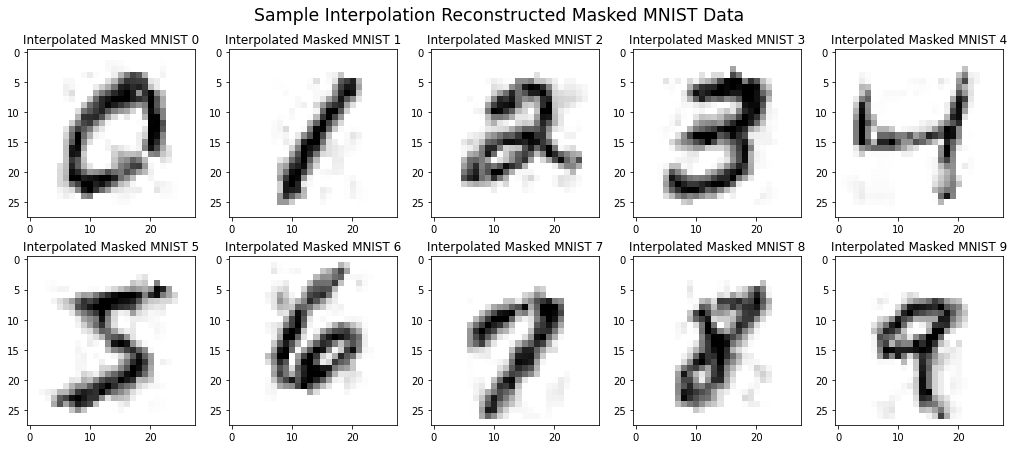

In [18]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 5, figsize=(17.5, 7))
for i in range(5):
    ax[0, i].imshow(X_subset_masked_int[y_subset == i][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[0,i].set_title(r'Interpolated Masked MNIST {}'.format(i))
    ax[1, i].imshow(X_subset_masked_int[y_subset == i+5][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1,i].set_title(r'Interpolated Masked MNIST {}'.format(i+5))
fig.suptitle(r'Sample Interpolation Reconstructed Masked MNIST Data',y=0.96,size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [19]:
# Train a single model on 3,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class 
X_train_masked_int, X_test_masked_int = X_subset_masked_int[:n_train], X_subset_masked_int[-n_train:]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train_masked_int, y_train)
acc_train_masked_int = model.score(X_train_masked_int, y_train)
acc_test_masked_int = model.score(X_test_masked_int, y_test)
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our interpolated masked training data.'.format(100*acc_train_masked_int)))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our interpolated masked test data.'.format(100*acc_test_masked_int)))

Our trained classifier correctly classifies 92.40% of our interpolated masked training data.

Our trained classifier correctly classifies 87.87% of our interpolated masked test data.

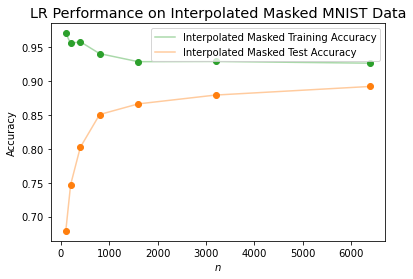

In [52]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_mint = np.zeros(7)
tests_mint = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset_masked_int[:n], y_subset[:n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains_mint[i] = model.score(X_tr, y_tr)
    tests_mint[i] = model.score(X_test_masked_int, y_test)
    
plt.plot(ns,trains_mint,label=r'Interpolated Masked Training Accuracy', alpha=0.4, color='C12')
plt.scatter(ns,trains_mint,color='C12')
plt.plot(ns,tests_mint,label=r'Interpolated Masked Test Accuracy', alpha=0.4, color='C11')
plt.scatter(ns,tests_mint,color='C11')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.legend()
plt.title(r'LR Performance on Interpolated Masked MNIST Data',size='x-large')
plt.show()

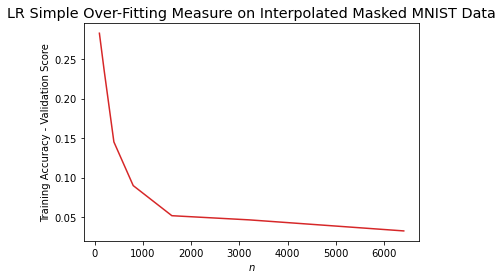

In [51]:
# Plot our simple overfitting measure as a function of n
diffs_mint = trains_mint - tests_mint
plt.plot(ns,diffs_mint,color='C13')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on Interpolated Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the Interpolated 50% Masked MNIST dataset converges to an asymptotic value of approximately 0.05 for $n$ greater than (roughly) 1,600. Although the training and test accuracies of these models are slightly lower than those of the models trained on the original MNIST dataset, the overfitting measures for these two ensembles are highly similar.

##### Convolutional Neural Network (CNN)

In [57]:
# Reshape training data for use in CNN models
X_train_masked_int_cnn, X_test_masked_int_cnn = X_train_masked_int.reshape(-1, 28, 28, 1), X_test_masked_int.reshape(-1, 28, 28, 1)

In [58]:
# Train a single model on 3,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class
model_masked_int = Sequential()

model_masked_int.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_masked_int.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_masked_int.add(MaxPooling2D(pool_size=(2, 2)))
model_masked_int.add(Dropout(0.25))
model_masked_int.add(Flatten())
model_masked_int.add(Dense(128, activation='relu'))
model_masked_int.add(Dropout(0.25))
model_masked_int.add(Dense(10, activation='softmax'))

model_masked_int.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history_masked_int = model_masked_int.fit(X_train_masked_int_cnn, y_train_cnn, batch_size=batch_size, epochs=epochs, 
                                          verbose=0, validation_data=(X_test_masked_int_cnn, y_test_cnn))

display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our interpolated masked training data.'.format(100*history_masked_int.history['accuracy'][-1])))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our interpolated masked test data.'.format(100*history_masked_int.history['val_accuracy'][-1])))

Our trained classifier correctly classifies 98.83% of our interpolated masked training data.

Our trained classifier correctly classifies 91.03% of our interpolated masked test data.

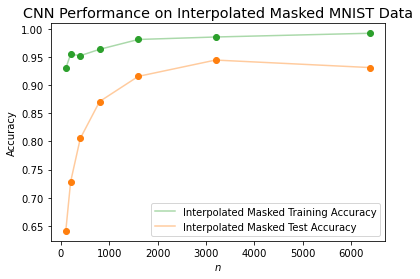

In [59]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_mint_cnn = np.zeros(7)
tests_mint_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_masked_int_cnn[:n], y_train_cnn[:n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    temp_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(2, 2)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(128, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(10, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_masked_int_cnn, y_test_cnn))
    trains_mint_cnn[i] = temp_history.history['accuracy'][-1]
    tests_mint_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_mint_cnn,label=r'Interpolated Masked Training Accuracy', alpha=0.4, color='C12')
plt.scatter(ns,trains_mint_cnn,color='C12')
plt.plot(ns,tests_mint_cnn,label=r'Interpolated Masked Test Accuracy', alpha=0.4, color='C11')
plt.scatter(ns,tests_mint_cnn,color='C11')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.legend()
plt.title(r'CNN Performance on Interpolated Masked MNIST Data',size='x-large')
plt.show()

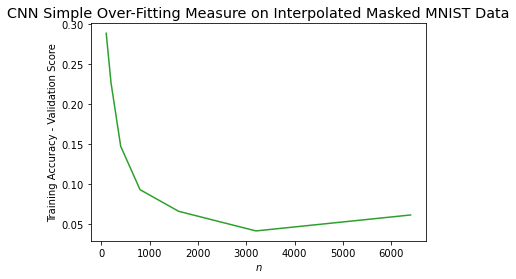

In [65]:
# Plot our simple overfitting measure as a function of n
diffs_mint_cnn = trains_mint_cnn - tests_mint_cnn
plt.plot(ns,diffs_mint_cnn,color='C2')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'CNN Simple Over-Fitting Measure on Interpolated Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the CNN models trained on the Interpolated 50% Masked MNIST dataset converges to an asymptotic value of approximately 0.06 for $n$ greater than (roughly) 3,000. This measure converges slightly slower than that of the models trained on the original MNIST dataset, but the measures are still fairly comparable.

#### FPC 50% Masked Dataset

We now examine the FPC 50% Masked MNIST dataset, and compare to results observed for the original dataset.

In [24]:
# Load the FPC 50% Masked MNIST dataset 
X_subset_masked_rr = np.array([np.genfromtxt('./MNist_csv_50pcentMasked_RR/MNIST{}_RR.csv'.format(i),delimiter=',')
                               for i in range(10000)])
X_subset_masked_rr = X_subset_masked_rr.reshape((X_subset.shape[0], -1))

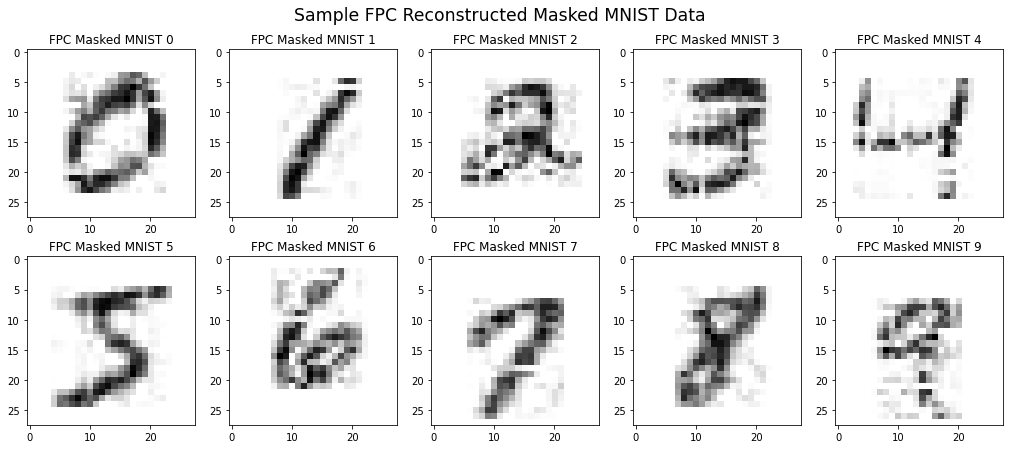

In [25]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 5, figsize=(17.5, 7))
for i in range(5):
    ax[0, i].imshow(X_subset_masked_rr[y_subset == i][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[0,i].set_title(r'FPC Masked MNIST {}'.format(i))
    ax[1, i].imshow(X_subset_masked_rr[y_subset == i+5][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1,i].set_title(r'FPC Masked MNIST {}'.format(i+5))
fig.suptitle(r'Sample FPC Reconstructed Masked MNIST Data',y=0.96,size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [26]:
# Train a single model on 3,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class
X_train_masked_rr, X_test_masked_rr = X_subset_masked_rr[:n_train], X_subset_masked_rr[-n_train:]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train_masked_rr, y_train)
acc_train_masked_rr = model.score(X_train_masked_rr, y_train)
acc_test_masked_rr = model.score(X_test_masked_rr, y_test)
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our rank-reduced masked training data.'.format(100*acc_train_masked_rr)))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our rank-reduced masked test data.'.format(100*acc_test_masked_rr)))

Our trained classifier correctly classifies 91.77% of our rank-reduced masked training data.

Our trained classifier correctly classifies 85.97% of our rank-reduced masked test data.

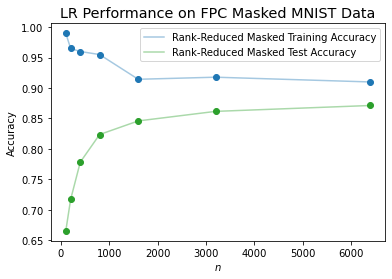

In [49]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_mrr = np.zeros(7)
tests_mrr = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset_masked_rr[:n], y_subset[:n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains_mrr[i] = model.score(X_tr, y_tr)
    tests_mrr[i] = model.score(X_test_masked_rr, y_test)
    
plt.plot(ns,trains_mrr,label=r'Rank-Reduced Masked Training Accuracy', alpha=0.4, color='C0')
plt.scatter(ns,trains_mrr,color='C0')
plt.plot(ns,tests_mrr,label=r'Rank-Reduced Masked Test Accuracy', alpha=0.4, color='C2')
plt.scatter(ns,tests_mrr,color='C2')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.legend()
plt.title(r'LR Performance on FPC Masked MNIST Data',size='x-large')
plt.show()

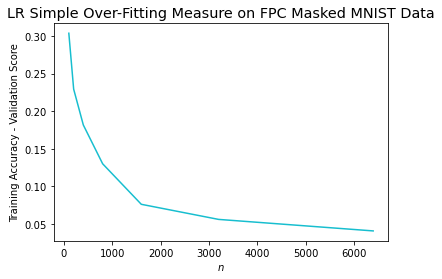

In [48]:
# Plot our simple overfitting measure as a function of n
diffs_mrr = trains_mrr - tests_mrr
plt.plot(ns,diffs_mrr,color='C9')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on FPC Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the FPC 50% Masked MNIST dataset converges to an asymptotic value of approximately 0.05 for $n$ greater than (roughly) 3,000. Although this measure approaches the same asymptote for both these models and those trained on the original MNIST dataset, the measure for these models requires roughly twice as many training samples to approach this asymptote, indicating a higher epistemic uncertainty associated with this dataset than the original.

##### Convolutional Neural Network (CNN)

In [60]:
# Reshape training data for use in CNN models
X_train_masked_rr_cnn, X_test_masked_rr_cnn = X_train_masked_rr.reshape(-1, 28, 28, 1), X_test_masked_rr.reshape(-1, 28, 28, 1)

In [61]:
# Train a single model on 3,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class
model_masked_rr = Sequential()

model_masked_rr.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_masked_rr.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_masked_rr.add(MaxPooling2D(pool_size=(2, 2)))
model_masked_rr.add(Dropout(0.25))
model_masked_rr.add(Flatten())
model_masked_rr.add(Dense(128, activation='relu'))
model_masked_rr.add(Dropout(0.25))
model_masked_rr.add(Dense(10, activation='softmax'))

model_masked_rr.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history_masked_rr = model_masked_rr.fit(X_train_masked_rr_cnn, y_train_cnn, batch_size=batch_size, epochs=epochs, 
                                        verbose=0, validation_data=(X_test_masked_rr_cnn, y_test_cnn))

display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our rank-reduced masked training data.'.format(100*history_masked_rr.history['accuracy'][-1])))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our rank-reduced masked test data.'.format(100*history_masked_rr.history['val_accuracy'][-1])))

Our trained classifier correctly classifies 98.13% of our rank-reduced masked training data.

Our trained classifier correctly classifies 91.70% of our rank-reduced masked test data.

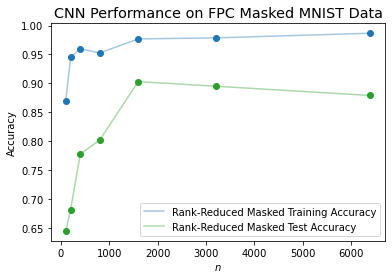

In [62]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_mrr_cnn = np.zeros(7)
tests_mrr_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_masked_rr_cnn[:n], y_train_cnn[:n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    temp_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(2, 2)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(128, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(10, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_masked_rr_cnn, y_test_cnn))
    trains_mrr_cnn[i] = temp_history.history['accuracy'][-1]
    tests_mrr_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_mrr_cnn,label=r'Rank-Reduced Masked Training Accuracy', alpha=0.4, color='C0')
plt.scatter(ns,trains_mrr_cnn,color='C0')
plt.plot(ns,tests_mrr_cnn,label=r'Rank-Reduced Masked Test Accuracy', alpha=0.4, color='C2')
plt.scatter(ns,tests_mrr_cnn,color='C2')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.legend()
plt.title(r'CNN Performance on FPC Masked MNIST Data',size='x-large')
plt.show()

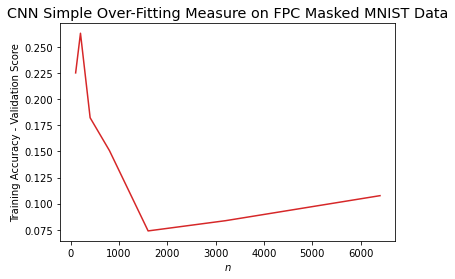

In [66]:
# Plot our simple overfitting measure as a function of n
diffs_mrr_cnn = trains_mrr_cnn - tests_mrr_cnn
plt.plot(ns,diffs_mrr_cnn,color='C3')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'CNN Simple Over-Fitting Measure on FPC Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the CNN models trained on the FPC 50% Masked MNIST dataset converges to an asymptotic value of approximately 0.08 for $n$ greater than (roughly) 2,500. The overfitting measure for these models again takes longer to converge than that for the models trained on the original MNIST dataset (higher epistemic uncertainty), however, unlike the LR models trained on this data, the asymptotic value of this measure (as well as the aleatoric uncertainty associated with this dataset) is greater than that for the models trained on the original set. 

#### Discussion of 50% Masked Dataset and Associated Reconstructions

We now compare the performance observed for the models trained on the original MNIST dataset, the 50% Masked MNIST dataset, and the two sets of associated reconstructed data. 

##### Logistic Regression (LR)

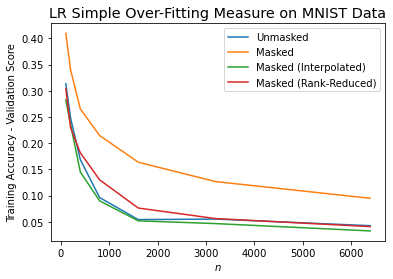

In [47]:
# Plot our simple overfitting measure as a function of n for each
# of the LR ensembles listed above
plt.plot(ns, diffs, label='Unmasked')
plt.plot(ns, diffs_m, label='Masked')
plt.plot(ns, diffs_mint, label='Masked (Interpolated)')
plt.plot(ns, diffs_mrr, label='Masked (Rank-Reduced)')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on MNIST Data',size='x-large')
plt.legend()
plt.show()

##### Convolutional Neural Network (CNN)

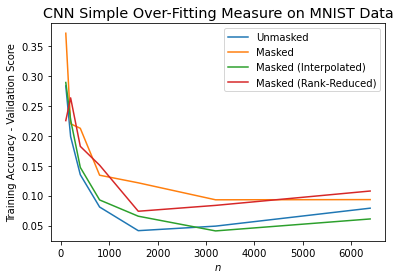

In [67]:
# Plot our simple overfitting measure as a function of n for each
# of the CNN ensembles listed above
plt.plot(ns, diffs_cnn, label='Unmasked')
plt.plot(ns, diffs_m_cnn, label='Masked')
plt.plot(ns, diffs_mint_cnn, label='Masked (Interpolated)')
plt.plot(ns, diffs_mrr_cnn, label='Masked (Rank-Reduced)')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'CNN Simple Over-Fitting Measure on MNIST Data',size='x-large')
plt.legend()
plt.show()

We observe from the plots of our overfitting measure above that the models trained on the images reconstructed via polynomial interpolation exhibit lower epistemic uncertainty than those trained on the images reconstructed via FPC, and even approximately matches the epistemic and aleatoric uncertainties associated with the original MNIST dataset. It appears that polynomial interpolation well-suited method of matrix reconstruction for low-dimensional matrices. 

As alluded to earlier, the results for the LR models trained on the FPC reconstructed data exhibit similar aleatoric uncertainty to those associated with the original MNIST set, but they also exhibit higher epistemic uncertainty. This is because FPC succeeds at de-noising the corrupted signals in this setting, but still returns matrices with lower rank than the originals. Additionally, the results for the CNN models trained on the FPC reconstructed data exhibit higher aleatoric uncertainty than those associated with the original MNIST set. This can be difficult to notice from the LR results in our current framework, as aleatoric uncertainty can also manifest as a decrease in both training and test accuracies for models trained on data that may not be linearly separable. This aleatoric uncertainty may be attributable to the low dimensionality of the MNIST datasets and the current level of masking, which can cause the low-rank matrix completion problem to be underdetermined (we are not guaranteed a uniquely optimal reconstruction via FPC).

Therefore, we note weaknesses of FPC for matrix reconstruction in low-dimensional settings with moderate levels of masking: 
1. Simpler, more computationally-efficient reconstructions (such as polynomial interpolation) may reduce aleatoric uncertainty associated with the corrupted signal more reliably.
2. Simpler, more computationally-efficient reconstructions (such as polynomial interpolation) may reduce epistemic uncertainty associated with the corrupted signal beyond the lower bound associated with a FPC reconstruction by producing reconstructions with unbound rank.

#### 80% Masked Dataset

We now examine the 80% Masked MNIST dataset, and compare to results observed for the original dataset.

In [68]:
# Load the 80% Masked MNIST dataset 
X_subset_masked = np.array([np.genfromtxt('./MNist_csv_80pcentMasked/MNIST{}.csv'.format(i),delimiter=',')
                            for i in range(10000)])
X_subset_masked = X_subset_masked.reshape((X_subset.shape[0], -1))

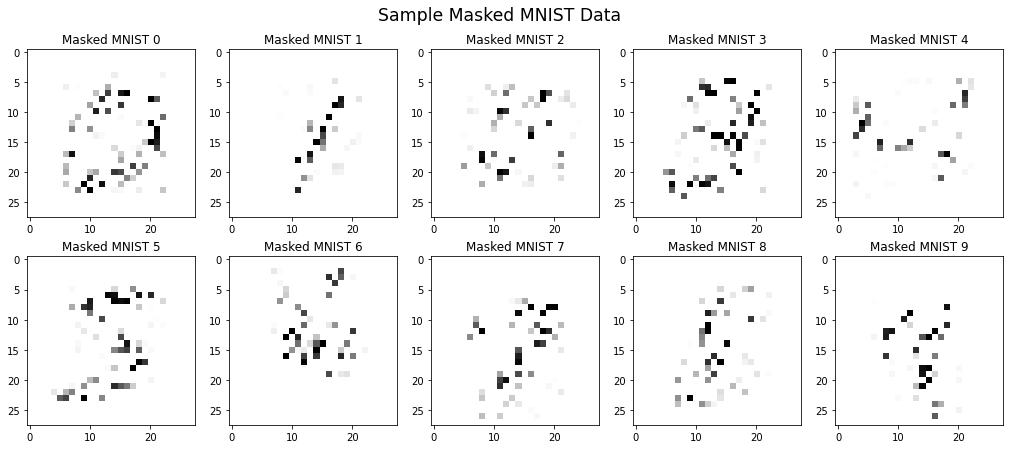

In [69]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 5, figsize=(17.5, 7))
for i in range(5):
    ax[0, i].imshow(X_subset_masked[y_subset == i][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[0,i].set_title(r'Masked MNIST {}'.format(i))
    ax[1, i].imshow(X_subset_masked[y_subset == i+5][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1,i].set_title(r'Masked MNIST {}'.format(i+5))
fig.suptitle(r'Sample Masked MNIST Data',y=0.96,size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [70]:
# Train a single model on 3,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class
X_train_masked, X_test_masked = X_subset_masked[:n_train], X_subset_masked[-n_train:]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train_masked, y_train)
acc_train_masked = model.score(X_train_masked, y_train)
acc_test_masked = model.score(X_test_masked, y_test)
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our masked training data.'.format(100*acc_train_masked)))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our masked test data.'.format(100*acc_test_masked)))

Our trained classifier correctly classifies 87.80% of our masked training data.

Our trained classifier correctly classifies 66.97% of our masked test data.

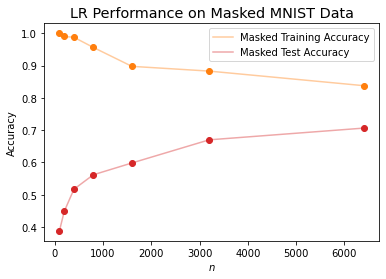

In [71]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_m = np.zeros(7)
tests_m = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset_masked[:n], y_subset[:n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains_m[i] = model.score(X_tr, y_tr)
    tests_m[i] = model.score(X_test_masked, y_test) 
    
plt.plot(ns,trains_m,label=r'Masked Training Accuracy', alpha=0.4, color='C1')
plt.scatter(ns,trains_m,color='C1')
plt.plot(ns,tests_m,label=r'Masked Test Accuracy', alpha=0.4, color='C3')
plt.scatter(ns,tests_m,color='C3')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'LR Performance on Masked MNIST Data',size='x-large')
plt.legend()
plt.show()

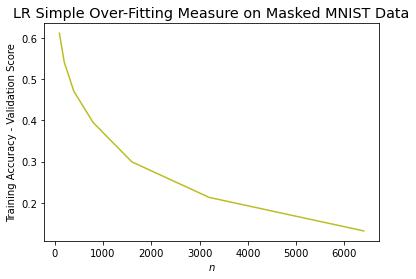

In [72]:
# Plot our simple overfitting measure as a function of n
diffs_m = trains_m - tests_m
plt.plot(ns,diffs_m,color='C8')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the 80% Masked MNIST dataset does not converge to an asymptotic value for $n\le6,400$. This is expected, as it was for the models trained on the set with 50% masking. Naturally, we observe a greater degree of overfitting, as increased masking contributes to increased aleatoric uncertainty.

##### Convolutional Neural Network (CNN)

In [90]:
# Reshape training data for use in CNN models
X_train_masked_cnn, X_test_masked_cnn = X_train_masked.reshape(-1, 28, 28, 1), X_test_masked.reshape(-1, 28, 28, 1)

In [91]:
# Train a single model on 3,000 samples to guage the  asymptotic
# value of our overfitting measure for this dataset/model class 
model_masked = Sequential()

model_masked.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_masked.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_masked.add(MaxPooling2D(pool_size=(2, 2)))
model_masked.add(Dropout(0.25))
model_masked.add(Flatten())
model_masked.add(Dense(128, activation='relu'))
model_masked.add(Dropout(0.25))
model_masked.add(Dense(10, activation='softmax'))

model_masked.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history_masked = model_masked.fit(X_train_masked_cnn, y_train_cnn, batch_size=batch_size, epochs=epochs, 
                                  verbose=0, validation_data=(X_test_masked_cnn, y_test_cnn))

display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our masked training data.'.format(100*history_masked.history['accuracy'][-1])))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our masked test data.'.format(100*history_masked.history['val_accuracy'][-1])))

Our trained classifier correctly classifies 97.20% of our masked training data.

Our trained classifier correctly classifies 78.40% of our masked test data.

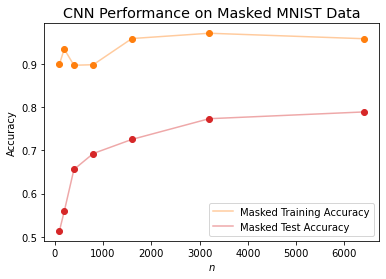

In [92]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_m_cnn = np.zeros(7)
tests_m_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_masked_cnn[:n], y_train_cnn[:n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    temp_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(2, 2)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(128, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(10, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_masked_cnn, y_test_cnn))
    trains_m_cnn[i] = temp_history.history['accuracy'][-1]
    tests_m_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_m_cnn,label=r'Masked Training Accuracy', alpha=0.4, color='C1')
plt.scatter(ns,trains_m_cnn,color='C1')
plt.plot(ns,tests_m_cnn,label=r'Masked Test Accuracy', alpha=0.4, color='C3')
plt.scatter(ns,tests_m_cnn,color='C3')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'CNN Performance on Masked MNIST Data',size='x-large')
plt.legend()
plt.show()

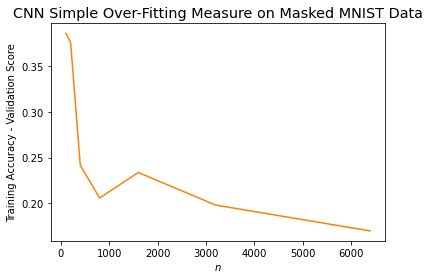

In [93]:
# Plot our simple overfitting measure as a function of n
diffs_m_cnn = trains_m_cnn - tests_m_cnn
plt.plot(ns,diffs_m_cnn,color='C1')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'CNN Simple Over-Fitting Measure on Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the CNN models trained on the 80% Masked MNIST dataset converges to an asymptotic value of approximately 0.18 for $n$ greater than (roughly) 6,000. Again, this slower convergence and higher asymptotic value are expected due to the increased uncertainty associated with the masked data, and these observations are more pronounced for these models than for those trained on the data with 50% masking.

#### Interpolated 80% Masked Dataset

We now examine the Interpolated 80% Masked MNIST dataset, and compare to results observed for the original dataset.

In [73]:
# Load the Interpolated 80% Masked MNIST dataset
X_subset_masked_int = np.array([np.genfromtxt('./MNist_csv_80pcentMasked_Int/MNIST{}_Int.csv'.format(i),delimiter=',')
                               for i in range(10000)])
X_subset_masked_int = X_subset_masked_int.reshape((X_subset.shape[0], -1))

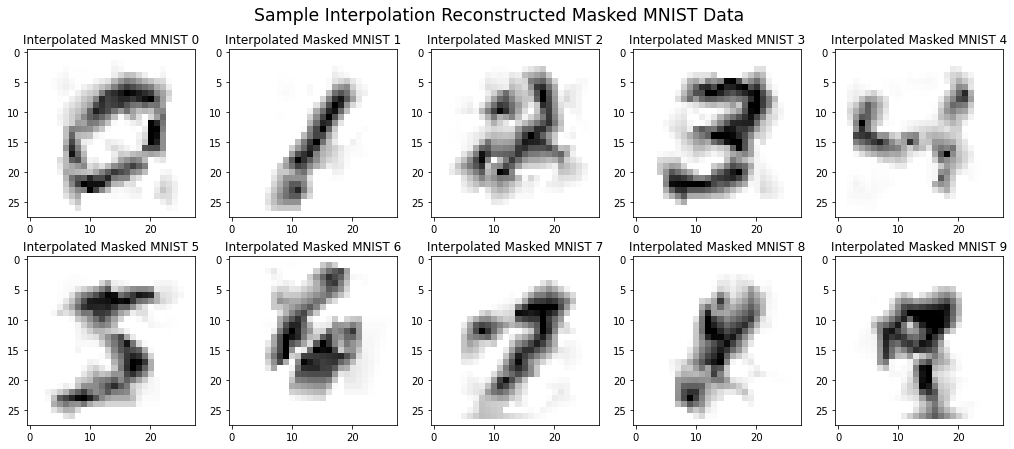

In [74]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 5, figsize=(17.5, 7))
for i in range(5):
    ax[0, i].imshow(X_subset_masked_int[y_subset == i][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[0,i].set_title(r'Interpolated Masked MNIST {}'.format(i))
    ax[1, i].imshow(X_subset_masked_int[y_subset == i+5][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1,i].set_title(r'Interpolated Masked MNIST {}'.format(i+5))
fig.suptitle(r'Sample Interpolation Reconstructed Masked MNIST Data',y=0.96,size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [75]:
# Train a single model on 3,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class
X_train_masked_int, X_test_masked_int = X_subset_masked_int[:n_train], X_subset_masked_int[-n_train:]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train_masked_int, y_train)
acc_train_masked_int = model.score(X_train_masked_int, y_train)
acc_test_masked_int = model.score(X_test_masked_int, y_test)
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our interpolated masked training data.'.format(100*acc_train_masked_int)))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our interpolated masked test data.'.format(100*acc_test_masked_int)))

Our trained classifier correctly classifies 86.80% of our interpolated masked training data.

Our trained classifier correctly classifies 81.13% of our interpolated masked test data.

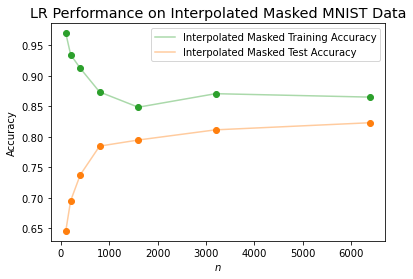

In [76]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_mint = np.zeros(7)
tests_mint = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset_masked_int[:n], y_subset[:n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains_mint[i] = model.score(X_tr, y_tr)
    tests_mint[i] = model.score(X_test_masked_int, y_test)
    
plt.plot(ns,trains_mint,label=r'Interpolated Masked Training Accuracy', alpha=0.4, color='C12')
plt.scatter(ns,trains_mint,color='C12')
plt.plot(ns,tests_mint,label=r'Interpolated Masked Test Accuracy', alpha=0.4, color='C11')
plt.scatter(ns,tests_mint,color='C11')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.legend()
plt.title(r'LR Performance on Interpolated Masked MNIST Data',size='x-large')
plt.show()

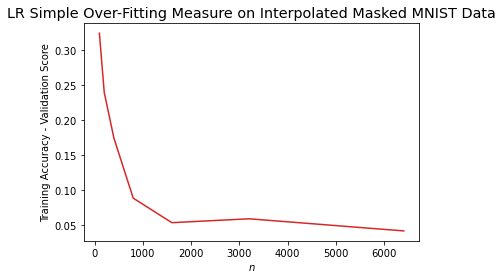

In [77]:
# Plot our simple overfitting measure as a function of n
diffs_mint = trains_mint - tests_mint
plt.plot(ns,diffs_mint,color='C13')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on Interpolated Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the Interpolated 80% Masked MNIST dataset converges to an asymptotic value of approximately 0.05 for $n$ greater than (roughly) 1,600. Despite increased masking, these results once again mirror those of the models trained on the original MNIST dataset, athough training and test accuracies decrease substantially (indicating an increase in aleatoric uncertainty from that associated with the original dataset). 

##### Convolutional Neural Network (CNN)

In [94]:
# Reshape training data for use in CNN models
X_train_masked_int_cnn, X_test_masked_int_cnn = X_train_masked_int.reshape(-1, 28, 28, 1), X_test_masked_int.reshape(-1, 28, 28, 1)

In [95]:
# Train a single model on 3,000 samples to guage the  asymptotic
# value of our overfitting measure for this dataset/model class 
model_masked_int = Sequential()

model_masked_int.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_masked_int.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_masked_int.add(MaxPooling2D(pool_size=(2, 2)))
model_masked_int.add(Dropout(0.25))
model_masked_int.add(Flatten())
model_masked_int.add(Dense(128, activation='relu'))
model_masked_int.add(Dropout(0.25))
model_masked_int.add(Dense(10, activation='softmax'))

model_masked_int.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history_masked_int = model_masked_int.fit(X_train_masked_int_cnn, y_train_cnn, batch_size=batch_size, epochs=epochs, 
                                          verbose=0, validation_data=(X_test_masked_int_cnn, y_test_cnn))

display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our interpolated masked training data.'.format(100*history_masked_int.history['accuracy'][-1])))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our interpolated masked test data.'.format(100*history_masked_int.history['val_accuracy'][-1])))

Our trained classifier correctly classifies 96.23% of our interpolated masked training data.

Our trained classifier correctly classifies 86.53% of our interpolated masked test data.

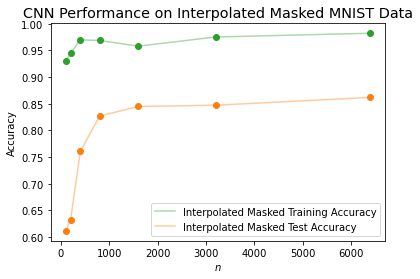

In [96]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_mint_cnn = np.zeros(7)
tests_mint_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_masked_int_cnn[:n], y_train_cnn[:n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    temp_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(2, 2)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(128, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(10, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_masked_int_cnn, y_test_cnn))
    trains_mint_cnn[i] = temp_history.history['accuracy'][-1]
    tests_mint_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_mint_cnn,label=r'Interpolated Masked Training Accuracy', alpha=0.4, color='C12')
plt.scatter(ns,trains_mint_cnn,color='C12')
plt.plot(ns,tests_mint_cnn,label=r'Interpolated Masked Test Accuracy', alpha=0.4, color='C11')
plt.scatter(ns,tests_mint_cnn,color='C11')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.legend()
plt.title(r'CNN Performance on Interpolated Masked MNIST Data',size='x-large')
plt.show()

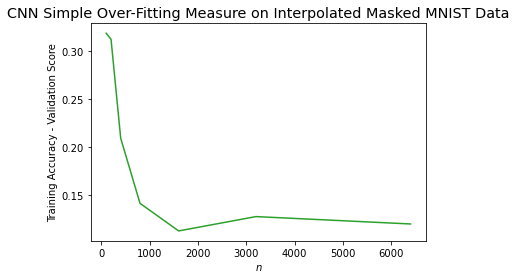

In [97]:
# Plot our simple overfitting measure as a function of n
diffs_mint_cnn = trains_mint_cnn - tests_mint_cnn
plt.plot(ns,diffs_mint_cnn,color='C2')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'CNN Simple Over-Fitting Measure on Interpolated Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the CNN models trained on the Interpolated 80% Masked MNIST dataset converges to an asymptotic value of approximately 0.12 for $n$ greater than (roughly) 2,000. This measure still converges as the same rate as that for the models trained on the original MNIST data, but the asymptotic value we observe here is now higher than that for models trained on the original data. This indicates an increase in aleatoric uncertainty from that associated with the original MNIST dataset (as mentioned in the dicussion of the LR models trained on this dataset). This results from the noise introduced in the interpolation, which naturally grows with the amount of masking in the associated corrupted signal.

#### FPC 80% Masked Dataset

We now examine the FPC 80% Masked MNIST dataset, and compare to results observed for the original dataset.

In [78]:
# Load the FPC 80% Masked MNIST dataset 
X_subset_masked_rr = np.array([np.genfromtxt('./MNist_csv_80pcentMasked_RR/MNIST{}_RR.csv'.format(i),delimiter=',')
                               for i in range(10000)])
X_subset_masked_rr = X_subset_masked_rr.reshape((X_subset.shape[0], -1))

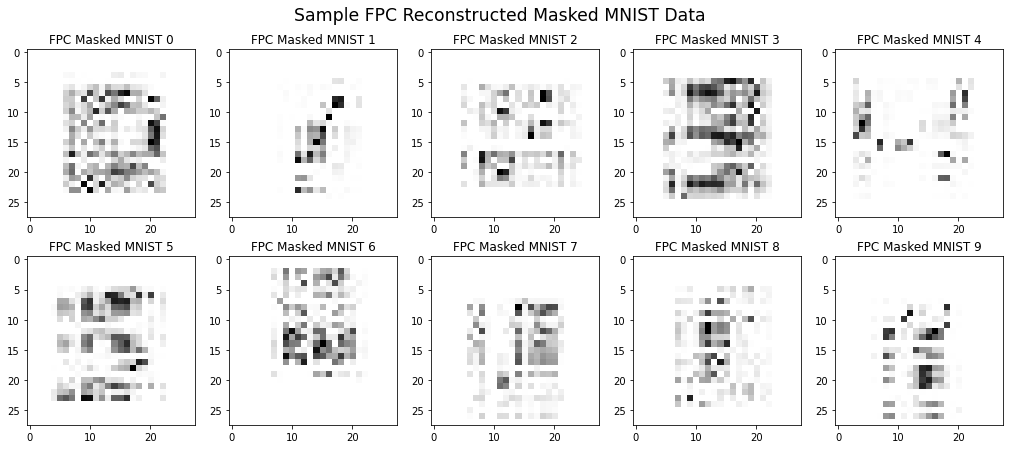

In [79]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 5, figsize=(17.5, 7))
for i in range(5):
    ax[0, i].imshow(X_subset_masked_rr[y_subset == i][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[0,i].set_title(r'FPC Masked MNIST {}'.format(i))
    ax[1, i].imshow(X_subset_masked_rr[y_subset == i+5][0].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1,i].set_title(r'FPC Masked MNIST {}'.format(i+5))
fig.suptitle(r'Sample FPC Reconstructed Masked MNIST Data',y=0.96,size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [80]:
# Train a single model on 3,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class
X_train_masked_rr, X_test_masked_rr = X_subset_masked_rr[:n_train], X_subset_masked_rr[-n_train:]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train_masked_rr, y_train)
acc_train_masked_rr = model.score(X_train_masked_rr, y_train)
acc_test_masked_rr = model.score(X_test_masked_rr, y_test)
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our rank-reduced masked training data.'.format(100*acc_train_masked_rr)))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our rank-reduced masked test data.'.format(100*acc_test_masked_rr)))

Our trained classifier correctly classifies 84.23% of our rank-reduced masked training data.

Our trained classifier correctly classifies 67.57% of our rank-reduced masked test data.

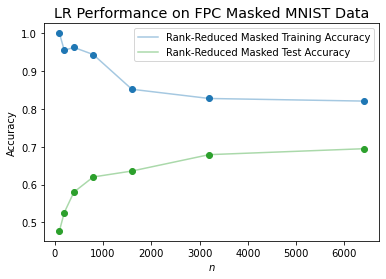

In [81]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_mrr = np.zeros(7)
tests_mrr = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset_masked_rr[:n], y_subset[:n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains_mrr[i] = model.score(X_tr, y_tr)
    tests_mrr[i] = model.score(X_test_masked_rr, y_test)
    
plt.plot(ns,trains_mrr,label=r'Rank-Reduced Masked Training Accuracy', alpha=0.4, color='C0')
plt.scatter(ns,trains_mrr,color='C0')
plt.plot(ns,tests_mrr,label=r'Rank-Reduced Masked Test Accuracy', alpha=0.4, color='C2')
plt.scatter(ns,tests_mrr,color='C2')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.legend()
plt.title(r'LR Performance on FPC Masked MNIST Data',size='x-large')
plt.show()

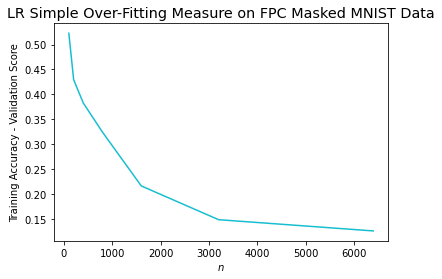

In [82]:
# Plot our simple overfitting measure as a function of n
diffs_mrr = trains_mrr - tests_mrr
plt.plot(ns,diffs_mrr,color='C9')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on FPC Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the FPC 80% Masked MNIST dataset converges to an asymptotic value of approximately 0.14 for $n$ greater than (roughly) 3,000, exhibiting an increase in both epistemic and aleatoric uncertainties from those associated with the original dataset.

##### Convolutional Neural Network (CNN)

In [98]:
# Reshape training data for use in CNN models
X_train_masked_rr_cnn, X_test_masked_rr_cnn = X_train_masked_rr.reshape(-1, 28, 28, 1), X_test_masked_rr.reshape(-1, 28, 28, 1)

In [99]:
# Train a single model on 3,000 samples to guage the  asymptotic
# value of our overfitting measure for this dataset/model class 
model_masked_rr = Sequential()

model_masked_rr.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_masked_rr.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_masked_rr.add(MaxPooling2D(pool_size=(2, 2)))
model_masked_rr.add(Dropout(0.25))
model_masked_rr.add(Flatten())
model_masked_rr.add(Dense(128, activation='relu'))
model_masked_rr.add(Dropout(0.25))
model_masked_rr.add(Dense(10, activation='softmax'))

model_masked_rr.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history_masked_rr = model_masked_rr.fit(X_train_masked_rr_cnn, y_train_cnn, batch_size=batch_size, epochs=epochs, 
                                        verbose=0, validation_data=(X_test_masked_rr_cnn, y_test_cnn))

display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our rank-reduced masked training data.'.format(100*history_masked_rr.history['accuracy'][-1])))
display(Markdown(r'Our trained classifier correctly classifies ' +
                 r'{:.2f}% of our rank-reduced masked test data.'.format(100*history_masked_rr.history['val_accuracy'][-1])))

Our trained classifier correctly classifies 96.20% of our rank-reduced masked training data.

Our trained classifier correctly classifies 69.97% of our rank-reduced masked test data.

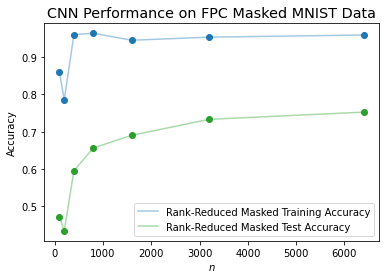

In [100]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains_mrr_cnn = np.zeros(7)
tests_mrr_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_masked_rr_cnn[:n], y_train_cnn[:n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    temp_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(2, 2)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(128, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(10, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_masked_rr_cnn, y_test_cnn))
    trains_mrr_cnn[i] = temp_history.history['accuracy'][-1]
    tests_mrr_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_mrr_cnn,label=r'Rank-Reduced Masked Training Accuracy', alpha=0.4, color='C0')
plt.scatter(ns,trains_mrr_cnn,color='C0')
plt.plot(ns,tests_mrr_cnn,label=r'Rank-Reduced Masked Test Accuracy', alpha=0.4, color='C2')
plt.scatter(ns,tests_mrr_cnn,color='C2')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.legend()
plt.title(r'CNN Performance on FPC Masked MNIST Data',size='x-large')
plt.show()

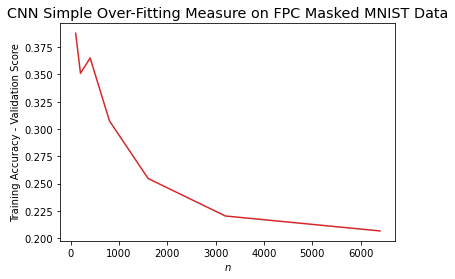

In [101]:
# Plot our simple overfitting measure as a function of n
diffs_mrr_cnn = trains_mrr_cnn - tests_mrr_cnn
plt.plot(ns,diffs_mrr_cnn,color='C3')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'CNN Simple Over-Fitting Measure on FPC Masked MNIST Data',size='x-large')
plt.show()

We find that overfitting measure for the CNN models trained on the FPC 80% Masked MNIST dataset converges to an asymptotic value of approximately 0.21 for $n$ greater than (roughly) 3,000, exhibiting a large increase in both epistemic and aleatoric uncertainties from those associated with the original dataset.

#### Discussion of 80% Masked Dataset and Associated Reconstructions

We now compare the performance observed for the models trained on the original MNIST dataset, the 80% Masked MNIST dataset, and the two sets of associated reconstructed data. 

##### Logistic Regression (LR)

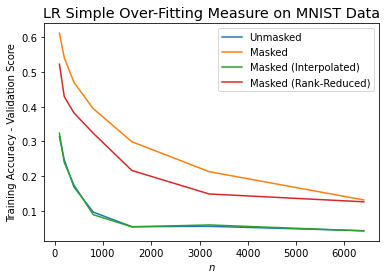

In [83]:
# Plot our simple overfitting measure as a function of n for each
# of the LR ensembles listed above
plt.plot(ns, diffs, label='Unmasked')
plt.plot(ns, diffs_m, label='Masked')
plt.plot(ns, diffs_mint, label='Masked (Interpolated)')
plt.plot(ns, diffs_mrr, label='Masked (Rank-Reduced)')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on MNIST Data',size='x-large')
plt.legend()
plt.show()

##### Convolutional Neural Network (CNN)

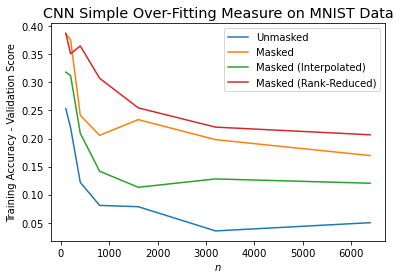

In [102]:
# Plot our simple overfitting measure as a function of n for each
# of the CNN ensembles listed above
plt.plot(ns, diffs_cnn, label='Unmasked')
plt.plot(ns, diffs_m_cnn, label='Masked')
plt.plot(ns, diffs_mint_cnn, label='Masked (Interpolated)')
plt.plot(ns, diffs_mrr_cnn, label='Masked (Rank-Reduced)')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'CNN Simple Over-Fitting Measure on MNIST Data',size='x-large')
plt.legend()
plt.show()

We observe from the plots of our overfitting measure above that the models trained on the images reconstructed via polynomial interpolation exhibit lower epistemic uncertainty than those trained on the images reconstructed via FPC, and even approximately matches the epistemic uncertainty associated with the original MNIST dataset. We note that the aleatoric uncertainty associated with this reconstruction is greater than that associated with the original dataset, but this is still an improvement over the corrupted set. 

As mentioned to earlier, the results for the LR models trained on the FPC reconstructed data exhibit much higher aleatoric uncertainty than those associated with the original MNIST set, along with higher epistemic uncertainty. This is because FPC does not succeed at de-noising the corrupted signals in this setting with high levels of masking, and still returns matrices with lower rank than the originals. Additionally, the results for the CNN models trained on the FPC reconstructed data even exhibit higher aleatoric uncertainty than those associated with the 80% Masked MNIST set. This aleatoric uncertainty may be attributable to the low dimensionality of the MNIST datasets and the high level of masking, which can cause the low-rank matrix completion problem to be underdetermined (we are not guaranteed a uniquely optimal reconstruction via FPC, which may even introduce noise to the reconstructed samples).

Therefore, we note weaknesses of FPC for matrix reconstruction in low-dimensional settings with high levels of masking: 
1. Simpler, more computationally-efficient reconstructions (such as polynomial interpolation) may reduce aleatoric uncertainty associated with the corrupted signal more reliably (although not entirely).
2. Simpler, more computationally-efficient reconstructions (such as polynomial interpolation) may reduce epistemic uncertainty associated with the corrupted signal beyond the lower bound associated with a FPC reconstruction by producing reconstructions with unbound rank.
3. FPC may introduce noise during reconstruction that increases both epistemic and aleatoric uncertainty from those associated with a corrupted signal with high levels of masking

### Deep Weeds Datasets

Note that the subsections below contain CNN models trained on the reconstruction the of the corrupted Deep Weeds dataset, although these models exhibit poor predictive performance. For this reason, discussion of results relating to these models is limited, and we do not display the simple overfitting measure associated with these models.

#### Original Dataset

We first generate a baseline overfitting measure for the Deep Weeds datatsets by training our models on the original data.

In [2]:
# Load the Deep Weeds dataset
X_subset = np.array([np.genfromtxt('./deep_weeds_csv_raw/weed{}.csv'.format(i),delimiter=',')[1:,1:] for i in range(10000)])
y_subset = np.genfromtxt('./deep_weeds_csv_raw/weed_y.csv',delimiter=',')[1:,1:]
y_subset = y_subset.astype(int)
y_subset = y_subset.flatten()
X_subset = X_subset.reshape((X_subset.shape[0], -1))

labels = ['Chinee apple',
          'Lantana',
          'Parkinsonia',
          'Parthenium',
          'Prickly acacia',
          'Rubber vine',
          'Siam weed',
          'Snake weed',
          'Negative']

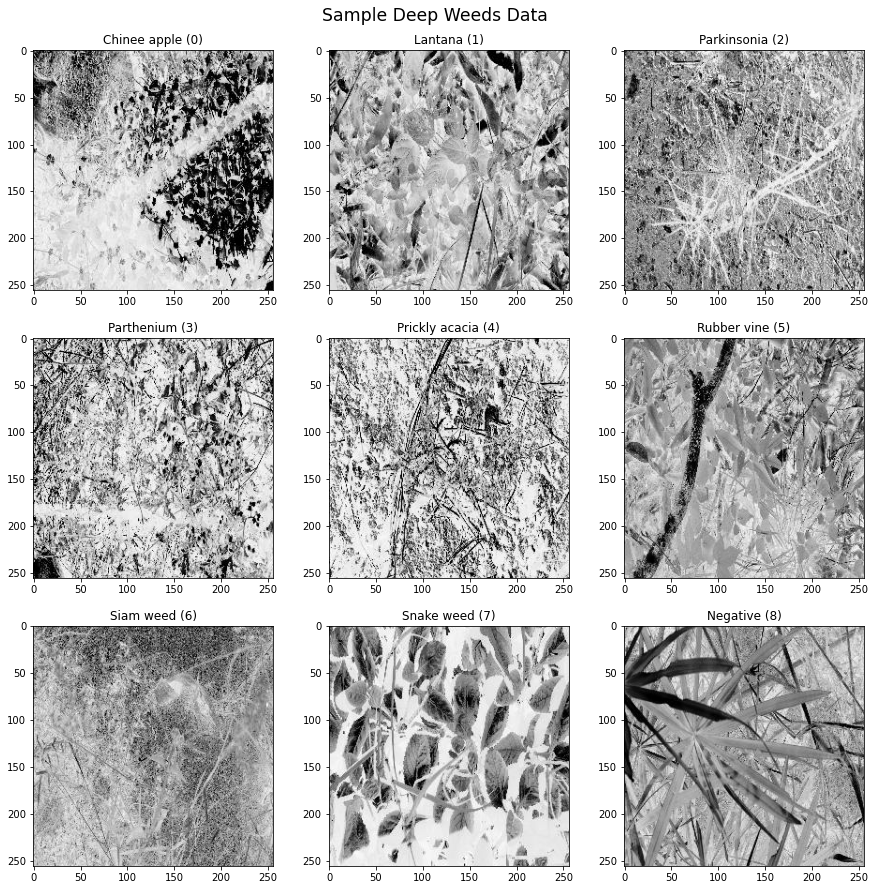

In [3]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    ax[0, i].imshow(X_subset[y_subset == i][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[0, i].set_title('{} ({})'.format(labels[i],i))
    ax[1, i].imshow(X_subset[y_subset == i+3][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[1, i].set_title('{} ({})'.format(labels[i+3],i+3))
    ax[2, i].imshow(X_subset[y_subset == i+6][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[2, i].set_title('{} ({})'.format(labels[i+6],i+6))
fig.suptitle(r'Sample Deep Weeds Data', y=0.92, size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [4]:
# Train a single model on 1,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class
n_train = 3000
n_test = 800

X_test, y_test = X_subset[:n_test], y_subset[:n_test]
X_train, y_train = X_subset[n_test:n_test+n_train], y_subset[n_test:n_test+n_train]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train, y_train)
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our training data.'.format(100*acc_train)))
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our test data.'.format(100*acc_test)))

Our trained classifier correctly classifies 76.03% of our training data.

Our trained classifier correctly classifies 52.88% of our test data.

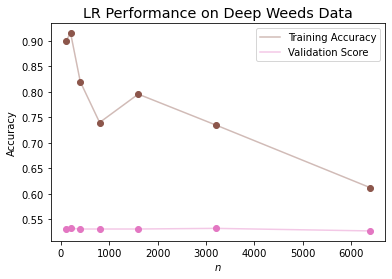

In [5]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [100*2**i for i in range(7)]
trains = np.zeros(7)
tests = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset[n_test:n+n_test], y_subset[n_test:n_test+n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains[i] = model.score(X_tr, y_tr)
    tests[i] = model.score(X_test, y_test)
    
plt.plot(ns,trains,label=r'Training Accuracy', alpha=0.4, color='C5')
plt.scatter(ns,trains,color='C5')
plt.plot(ns,tests,label=r'Validation Score', alpha=0.4, color='C6')
plt.scatter(ns,tests,color='C6')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'LR Performance on Deep Weeds Data',size='x-large')
plt.legend()
plt.show()

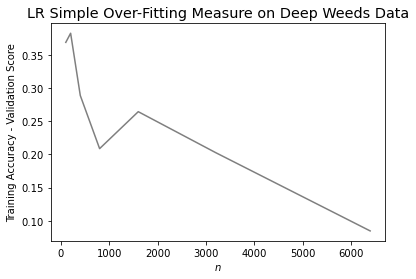

In [6]:
# Plot our simple overfitting measure as a function of n
diffs = trains - tests
plt.plot(ns,diffs,color='C7')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on Deep Weeds Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the MNIST dataset does not converge to an asymptotic value for $n\le6,400$ (likely due to the high dimensionality of the data and the poor suitability of LR models for this predictive task). Regardless, we can still use this plot as a baseline to inform our discussion of the related corrupted and reconstructed datasets.

##### Convolutional Neural Network (CNN)

We demonstrate the poor performance of our CNN architecture on the Deep Weeds dataset, which limits the conclusions that we can draw by comparing performance across this baseline, the 50% Masked Deep Weeds dataset and the associated reconstructions.

In [7]:
# Reshape training data for use in CNN models
X_train_cnn, X_test_cnn = X_train.reshape(-1, 256, 256, 1), X_test.reshape(-1, 256, 256, 1)

y_train_cnn, y_test_cnn = np.zeros((y_train.size, y_train.max()+1)), np.zeros((y_test.size, y_test.max()+1))
y_train_cnn[np.arange(y_train.size),y_train] = 1
y_test_cnn[np.arange(y_test.size) ,y_test] = 1

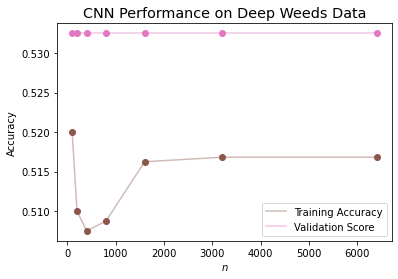

In [9]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
batch_size = 128
epochs = 10

ns = [100*2**i for i in range(7)]
trains_cnn = np.zeros(7)
tests_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_cnn[n_test:n_test+n], y_train_cnn[n_test:n_test+n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(16, 16), strides=(8,8), activation='relu', input_shape=(256, 256, 1)))
    temp_model.add(Conv2D(64, kernel_size=(8, 8), strides=(2,2), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(3, 3)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(256, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(9, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_cnn, y_test_cnn))
    trains_cnn[i] = temp_history.history['accuracy'][-1]
    tests_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_cnn,label=r'Training Accuracy', alpha=0.4, color='C5')
plt.scatter(ns,trains_cnn,color='C5')
plt.plot(ns,tests_cnn,label=r'Validation Score', alpha=0.4, color='C6')
plt.scatter(ns,tests_cnn,color='C6')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'CNN Performance on Deep Weeds Data',size='x-large')
plt.legend()
plt.show()

#### 50% Masked Dataset

We now examine the 50% Masked Deep Weeds dataset, and compare to results observed for the original dataset.

In [10]:
# Load the 50% Masked Deep Weeds dataset 
X_subset_masked = np.array([np.genfromtxt('./deep_weeds_csv_50pcentMasked/weed{}.csv'.format(i),delimiter=',')
                            for i in range(6000)])
X_subset_masked = X_subset_masked.reshape((X_subset_masked.shape[0], -1))
y_subset = y_subset[:6000]

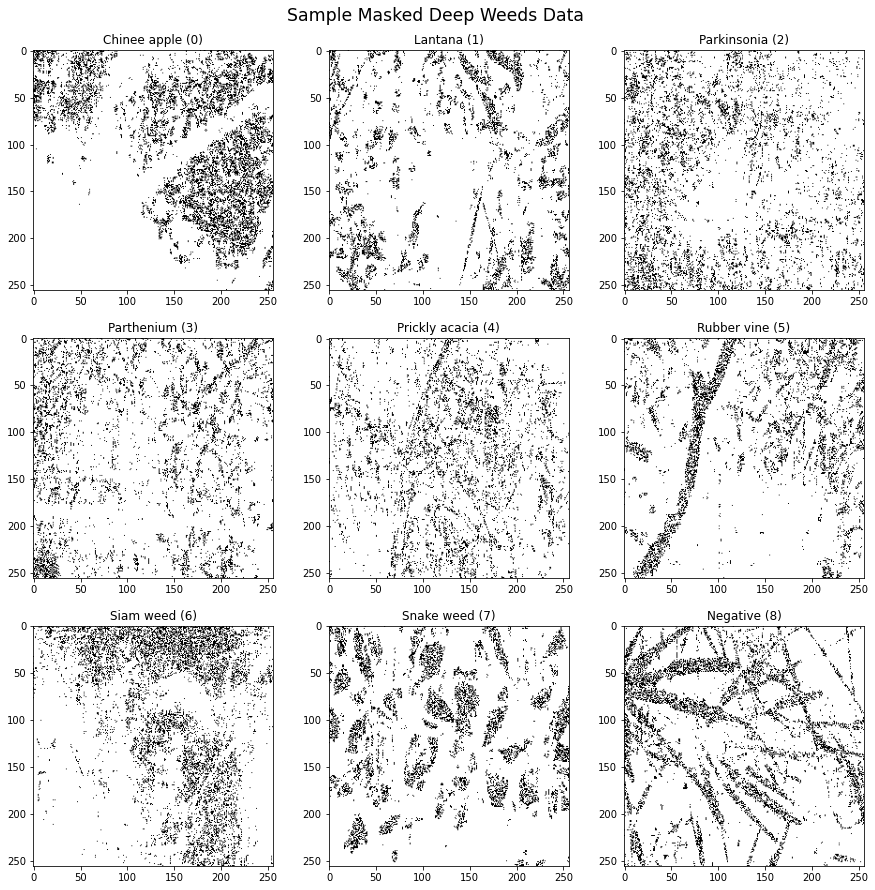

In [11]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    ax[0, i].imshow(X_subset_masked[y_subset == i][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[0, i].set_title('{} ({})'.format(labels[i],i))
    ax[1, i].imshow(X_subset_masked[y_subset == i+3][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[1, i].set_title('{} ({})'.format(labels[i+3],i+3))
    ax[2, i].imshow(X_subset_masked[y_subset == i+6][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[2, i].set_title('{} ({})'.format(labels[i+6],i+6))
fig.suptitle(r'Sample Masked Deep Weeds Data', y=0.92, size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [12]:
# Train a single model on 1,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class
X_test_masked, X_train_masked = X_subset_masked[:n_test], X_subset_masked[n_test:n_test+n_train]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train_masked, y_train)
acc_train_masked = model.score(X_train_masked, y_train)
acc_test_masked = model.score(X_test_masked, y_test)
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our masked training data.'.format(100*acc_train_masked)))
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our masked test data.'.format(100*acc_test_masked)))

Our trained classifier correctly classifies 96.37% of our masked training data.

Our trained classifier correctly classifies 53.25% of our masked test data.

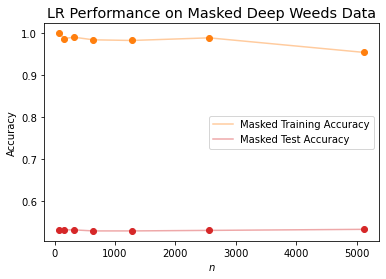

In [13]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [80*2**i for i in range(7)]
trains_m = np.zeros(7)
tests_m = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset_masked[n_test:n+n_test], y_subset[n_test:n_test+n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains_m[i] = model.score(X_tr, y_tr)
    tests_m[i] = model.score(X_test_masked, y_test)
    
plt.plot(ns,trains_m,label=r'Masked Training Accuracy', alpha=0.4, color='C1')
plt.scatter(ns,trains_m,color='C1')
plt.plot(ns,tests_m,label=r'Masked Test Accuracy', alpha=0.4, color='C3')
plt.scatter(ns,tests_m,color='C3')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'LR Performance on Masked Deep Weeds Data',size='x-large')
plt.legend()
plt.show()

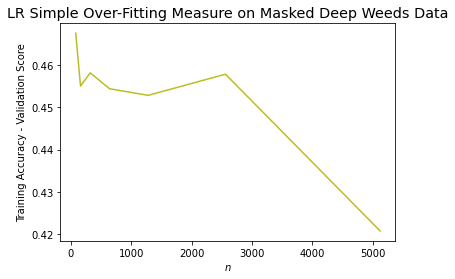

In [14]:
# Plot our simple overfitting measure as a function of n
diffs_m = trains_m - tests_m
plt.plot(ns,diffs_m,color='C8')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on Masked Deep Weeds Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the 50% Masked Deep Weeds dataset does not converge to an asymptotic value for $n\le1,280$ . This is expected, as it was for the models trained on the correupted MNIST datasets. Due to the limited number of samples in this dataset and both of the associated reconstructions, it is difficult to make claims regarding the epistemic uncertainty associated with each of these datasets. However, we observe a higher aleatoric uncertainty here than when discussing the original Deep Weeds dataset, as the values of our overfitting measure are far greater for models trained on this dataset than those for models trained on the original.

##### Convolutional Neural Network (CNN)

In [15]:
# Reshape training data for use in CNN models
X_train_masked_cnn, X_test_masked_cnn = X_train_masked.reshape(-1, 256, 256, 1), X_test_masked.reshape(-1, 256, 256, 1)

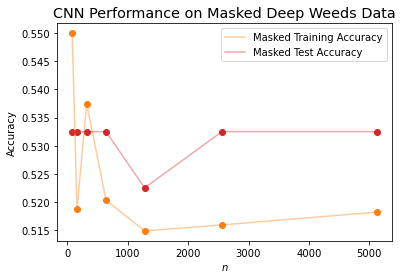

In [16]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n 
ns = [80*2**i for i in range(7)]
trains_m_cnn = np.zeros(7)
tests_m_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_masked_cnn[n_test:n_test+n], y_train_cnn[n_test:n_test+n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(16, 16), strides=(8,8), activation='relu', input_shape=(256, 256, 1)))
    temp_model.add(Conv2D(64, kernel_size=(8, 8), strides=(2,2), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(3, 3)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(256, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(9, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_masked_cnn, y_test_cnn))
    trains_m_cnn[i] = temp_history.history['accuracy'][-1]
    tests_m_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_m_cnn,label=r'Masked Training Accuracy', alpha=0.4, color='C1')
plt.scatter(ns,trains_m_cnn,color='C1')
plt.plot(ns,tests_m_cnn,label=r'Masked Test Accuracy', alpha=0.4, color='C3')
plt.scatter(ns,tests_m_cnn,color='C3')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'CNN Performance on Masked Deep Weeds Data',size='x-large')
plt.legend()
plt.show()

#### Interpolated 50% Masked Dataset

We now examine the Interpolated 50% Masked Deep Weeds dataset, and compare to results observed for the original dataset.

In [18]:
# Load the Interpolated 50% Masked Deep Weeds dataset 
X_subset_masked_int = np.array([np.genfromtxt('./deep_weeds_csv_50pcentMasked_Int/weed{}_Int.csv'.format(i),delimiter=',')
                                for i in range(6000)])
X_subset_masked_int = X_subset_masked_int.reshape((X_subset_masked.shape[0], -1))

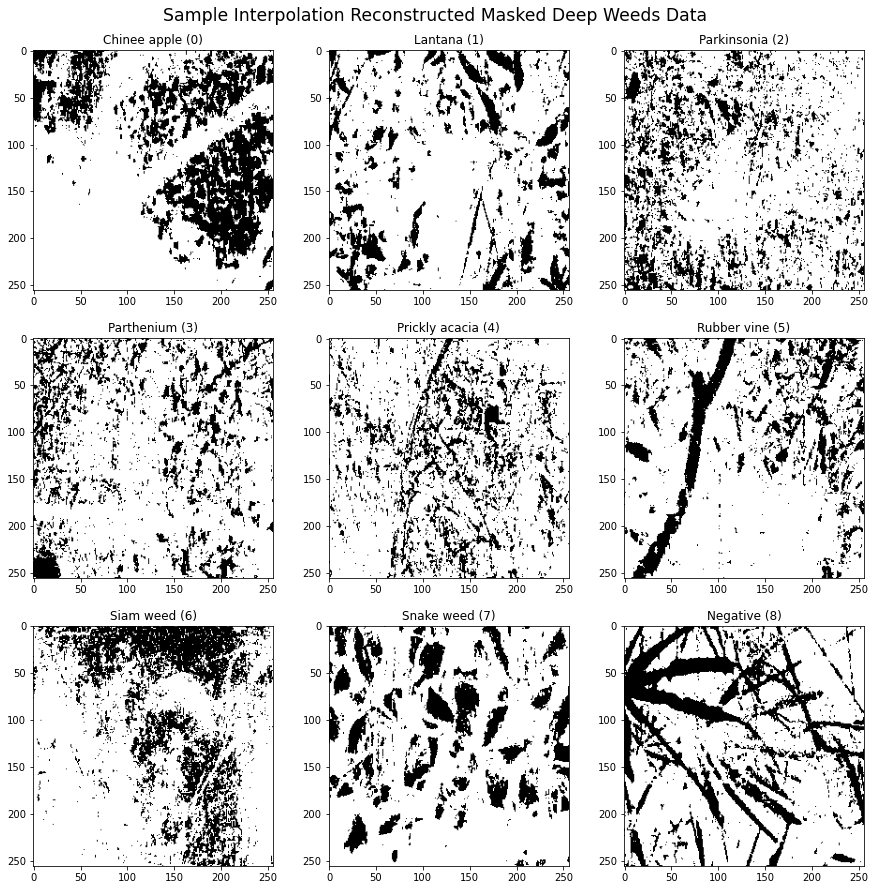

In [19]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    ax[0, i].imshow(X_subset_masked_int[y_subset == i][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[0, i].set_title('{} ({})'.format(labels[i],i))
    ax[1, i].imshow(X_subset_masked_int[y_subset == i+3][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[1, i].set_title('{} ({})'.format(labels[i+3],i+3))
    ax[2, i].imshow(X_subset_masked_int[y_subset == i+6][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[2, i].set_title('{} ({})'.format(labels[i+6],i+6))
fig.suptitle(r'Sample Interpolation Reconstructed Masked Deep Weeds Data', y=0.92, size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [20]:
# Train a single model on 1,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class
X_test_masked_int, X_train_masked_int = X_subset_masked_int[:n_test], X_subset_masked_int[n_test:n_test+n_train]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train_masked_int, y_train)
acc_train_masked_int = model.score(X_train_masked_int, y_train)
acc_test_masked_int = model.score(X_test_masked_int, y_test)
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our interpolated masked training data.'.format(100*acc_train_masked_int)))
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our interpolated masked test data.'.format(100*acc_test_masked_int)))

Our trained classifier correctly classifies 91.93% of our interpolated masked training data.

Our trained classifier correctly classifies 52.50% of our interpolated masked test data.

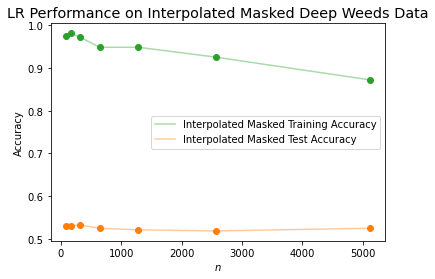

In [21]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [80*2**i for i in range(7)]
trains_mint = np.zeros(7)
tests_mint = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset_masked_int[n_test:n_test+n], y_subset[n_test:n_test+n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains_mint[i] = model.score(X_tr, y_tr)
    tests_mint[i] = model.score(X_test_masked_int, y_test)
    
plt.plot(ns,trains_mint,label=r'Interpolated Masked Training Accuracy', alpha=0.4, color='C12')
plt.scatter(ns,trains_mint,color='C12')
plt.plot(ns,tests_mint,label=r'Interpolated Masked Test Accuracy', alpha=0.4, color='C11')
plt.scatter(ns,tests_mint,color='C11')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.legend()
plt.title(r'LR Performance on Interpolated Masked Deep Weeds Data',size='x-large')
plt.show()

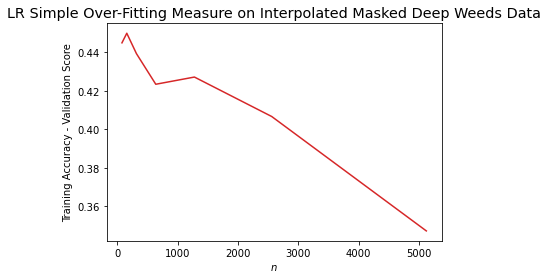

In [22]:
# Plot our simple overfitting measure as a function of n
diffs_mint = trains_mint - tests_mint
plt.plot(ns,diffs_mint,color='C13')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on Interpolated Masked Deep Weeds Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the Interpolated 50% Masked Deep Weeds dataset does not converge to an asymptotic value for $n\le1,280$ . Due to the limited number of samples in this dataset, it is difficult to make claims regarding the associated epistemic uncertainty. However, we observe an aleatoric uncertainty here that is higher than that associated with the original Deep Weeds dataset, but lower than that associated with the 50% Masked Deep Weeds dataset (although this latter comparison is weak due to the small size of these datasets).

##### Convolutional Neural Network (CNN)

In [23]:
# Reshape training data for use in CNN models
X_train_masked_int_cnn, X_test_masked_int_cnn = X_train_masked_int.reshape(-1, 256, 256, 1), X_test_masked_int.reshape(-1, 256, 256, 1)

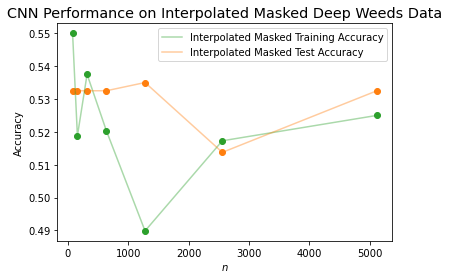

In [24]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [80*2**i for i in range(7)]
trains_mint_cnn = np.zeros(7)
tests_mint_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_masked_int_cnn[n_test:n_test+n], y_train_cnn[n_test:n_test+n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(16, 16), strides=(8,8), activation='relu', input_shape=(256, 256, 1)))
    temp_model.add(Conv2D(64, kernel_size=(8, 8), strides=(2,2), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(3, 3)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(256, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(9, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_masked_int_cnn, y_test_cnn))
    trains_mint_cnn[i] = temp_history.history['accuracy'][-1]
    tests_mint_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_mint_cnn,label=r'Interpolated Masked Training Accuracy', alpha=0.4, color='C12')
plt.scatter(ns,trains_mint_cnn,color='C12')
plt.plot(ns,tests_mint_cnn,label=r'Interpolated Masked Test Accuracy', alpha=0.4, color='C11')
plt.scatter(ns,tests_mint_cnn,color='C11')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'CNN Performance on Interpolated Masked Deep Weeds Data',size='x-large')
plt.legend()
plt.show()

#### FPC 50% Masked Dataset

We now examine the FPC 50% Masked Deep Weeds dataset, and compare to results observed for the original dataset.

In [25]:
# Load the FPC 50% Masked Deep Weeds dataset
X_subset_masked_rr = np.array([np.genfromtxt('./deep_weeds_csv_50pcentMasked_RR/weed{}_RR.csv'.format(i),delimiter=',')
                               for i in range(6000)])
X_subset_masked_rr = X_subset_masked_rr.reshape((X_subset_masked.shape[0], -1))

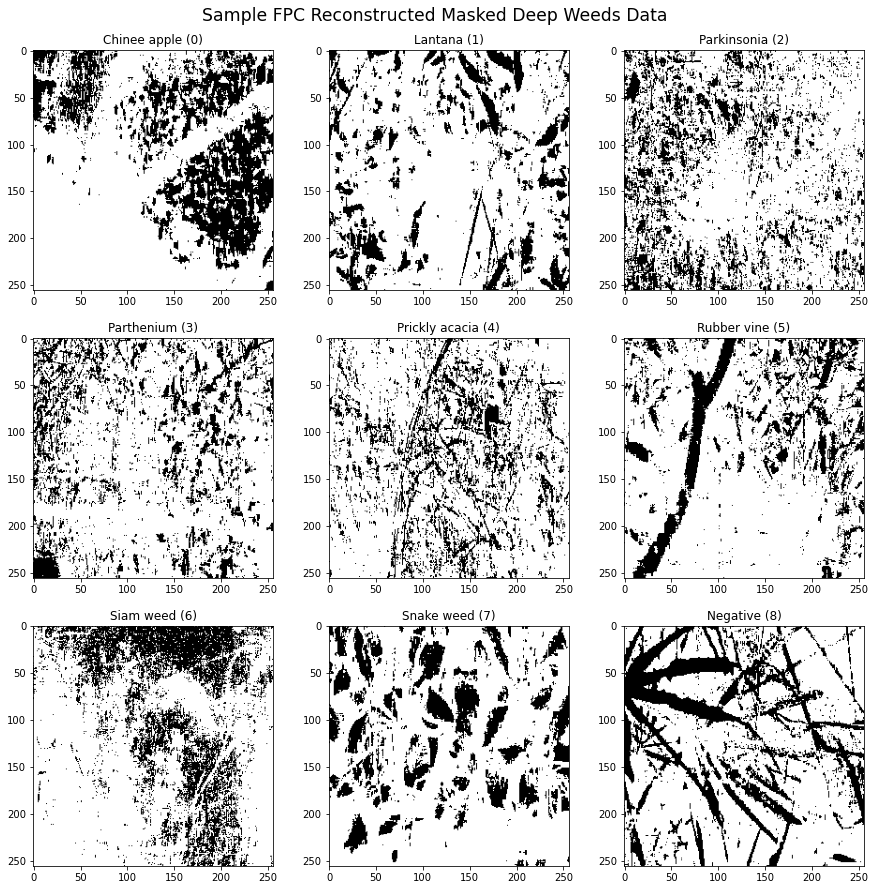

In [26]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    ax[0, i].imshow(X_subset_masked_rr[y_subset == i][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[0, i].set_title('{} ({})'.format(labels[i],i))
    ax[1, i].imshow(X_subset_masked_rr[y_subset == i+3][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[1, i].set_title('{} ({})'.format(labels[i+3],i+3))
    ax[2, i].imshow(X_subset_masked_rr[y_subset == i+6][0].reshape((256, 256)), cmap=plt.cm.gray_r)
    ax[2, i].set_title('{} ({})'.format(labels[i+6],i+6))
fig.suptitle(r'Sample FPC Reconstructed Masked Deep Weeds Data', y=0.92, size='xx-large')
plt.show()

##### Logistic Regression (LR)

In [27]:
# Train a single model on 1,000 samples to guage the asymptotic
# value of our overfitting measure for this dataset/model class
X_test_masked_rr, X_train_masked_rr = X_subset_masked_rr[:n_test], X_subset_masked_rr[n_test:n_test+n_train]

model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
model.fit(X_train_masked_rr, y_train)
acc_train_masked_rr = model.score(X_train_masked_rr, y_train)
acc_test_masked_rr = model.score(X_test_masked_rr, y_test)
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our rank-reduced masked training data.'.format(100*acc_train_masked_rr)))
display(Markdown(r'Our trained classifier correctly classifies {:.2f}% of our rank-reduced masked test data.'.format(100*acc_test_masked_rr)))

Our trained classifier correctly classifies 92.70% of our rank-reduced masked training data.

Our trained classifier correctly classifies 52.75% of our rank-reduced masked test data.

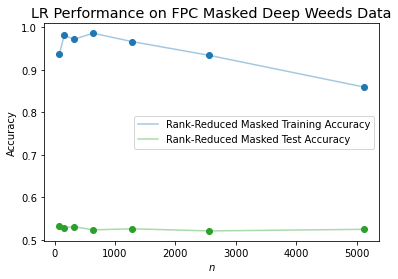

In [29]:
# Train an ensemble of LR models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [80*2**i for i in range(7)]
trains_mrr = np.zeros(7)
tests_mrr = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_subset_masked_rr[n_test:n_test+n], y_subset[n_test:n_test+n]
    model = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    model.fit(X_tr, y_tr)
    trains_mrr[i] = model.score(X_tr, y_tr)
    tests_mrr[i] = model.score(X_test_masked_rr, y_test)
    
plt.plot(ns,trains_mrr,label=r'Rank-Reduced Masked Training Accuracy', alpha=0.4, color='C0')
plt.scatter(ns,trains_mrr,color='C0')
plt.plot(ns,tests_mrr,label=r'Rank-Reduced Masked Test Accuracy', alpha=0.4, color='C2')
plt.scatter(ns,tests_mrr,color='C2')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.legend()
plt.title(r'LR Performance on FPC Masked Deep Weeds Data',size='x-large')
plt.show()

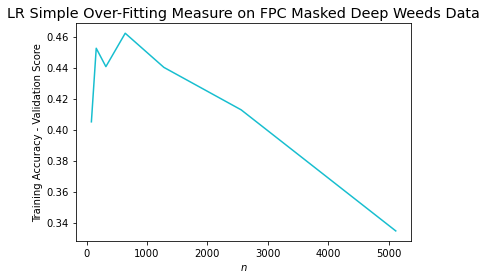

In [30]:
# Plot our simple overfitting measure as a function of n
diffs_mrr = trains_mrr - tests_mrr
plt.plot(ns,diffs_mrr,color='C9')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on FPC Masked Deep Weeds Data',size='x-large')
plt.show()

We find that overfitting measure for the LR models trained on the FPC 50% Masked Deep Weeds dataset does not converge to an asymptotic value for $n\le1,280$. Due to the limited number of samples in this dataset, it is difficult to make claims regarding the associated epistemic uncertainty. However, we observe an aleatoric uncertainty here that is higher than that associated with the original Deep Weeds dataset.

##### Convolutional Neural Network (CNN)

In [31]:
# Reshape training data for use in CNN models
X_train_masked_rr_cnn, X_test_masked_rr_cnn = X_train_masked_rr.reshape(-1, 256, 256, 1), X_test_masked_rr.reshape(-1, 256, 256, 1)

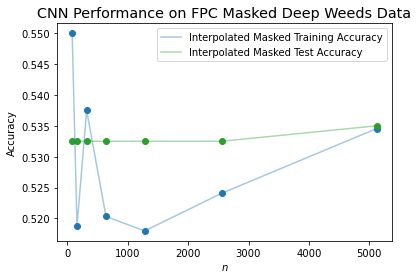

In [32]:
# Train an ensemble of CNN models on varying quantities n
# of training data and plot the training and test accuracies 
# of these models as a function of n
ns = [80*2**i for i in range(7)]
trains_mrr_cnn = np.zeros(7)
tests_mrr_cnn = np.zeros(7)
for i, n in enumerate(ns):
    X_tr, y_tr = X_train_masked_rr_cnn[n_test:n_test+n], y_train_cnn[n_test:n_test+n]

    temp_model = Sequential()

    temp_model.add(Conv2D(32, kernel_size=(16, 16), strides=(8,8), activation='relu', input_shape=(256, 256, 1)))
    temp_model.add(Conv2D(64, kernel_size=(8, 8), strides=(2,2), activation='relu'))
    temp_model.add(MaxPooling2D(pool_size=(3, 3)))
    temp_model.add(Dropout(0.25))
    temp_model.add(Flatten())
    temp_model.add(Dense(256, activation='relu'))
    temp_model.add(Dropout(0.25))
    temp_model.add(Dense(9, activation='softmax'))

    temp_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    temp_history = temp_model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                             verbose=0, validation_data=(X_test_masked_rr_cnn, y_test_cnn))
    trains_mrr_cnn[i] = temp_history.history['accuracy'][-1]
    tests_mrr_cnn[i] = temp_history.history['val_accuracy'][-1]
    
plt.plot(ns,trains_mrr_cnn,label=r'Interpolated Masked Training Accuracy', alpha=0.4, color='C0')
plt.scatter(ns,trains_mrr_cnn,color='C0')
plt.plot(ns,tests_mrr_cnn,label=r'Interpolated Masked Test Accuracy', alpha=0.4, color='C2')
plt.scatter(ns,tests_mrr_cnn,color='C2')
plt.xlabel(r'$n$')
plt.ylabel(r'Accuracy')
plt.title(r'CNN Performance on FPC Masked Deep Weeds Data',size='x-large')
plt.legend()
plt.show()

#### Discussion of 50% Masked Dataset and Associated Reconstructions

We now compare the performance observed for the models trained on the original Deep Weeds dataset, the 50% Masked Deep Weeds dataset, and the two sets of associated reconstructed data. 

##### Logistic Regression (LR)

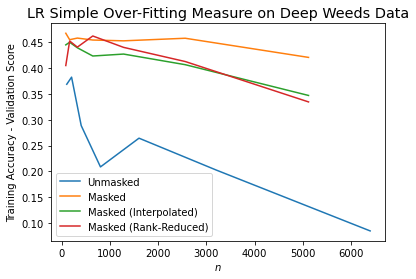

In [34]:
# Plot our simple overfitting measure as a function of n for each
# of the LR ensembles listed above
plt.plot([100*2**i for i in range(7)], diffs, label='Unmasked')
plt.plot(ns, diffs_m, label='Masked')
plt.plot(ns, diffs_mint, label='Masked (Interpolated)')
plt.plot(ns, diffs_mrr, label='Masked (Rank-Reduced)')
plt.xlabel(r'$n$')
plt.ylabel(r'Training Accuracy - Validation Score')
plt.title(r'LR Simple Over-Fitting Measure on Deep Weeds Data',size='x-large')
plt.legend()
plt.show()

We observe from the plot of our overfitting measures above that the models trained on the images reconstructed via polynomial interpolation exhibit slightly lower aleatoric uncertainty than those trained on the corrupted images or the images reconstructed via FPC, although this comparison is weak due to the limited number of samples in the corrupted and reconstructed datasets. We also note that the aleatoric uncertainty associated with this reconstruction is much greater than that associated with the original dataset. Similarly, the aleatoric uncertainty associated with the FPC reconstruction is also much greater than that associated with the original dataset.

We unfortunately cannot make comparisons regarding the epistemic uncertainties associated with each of these datasets due to the small size of the corrupted and reconstructed datasets, as we do not observe convergence of the overfitting measures associated with these datasets.

Therefore, we note the following regarding FPC for matrix reconstruction in high-dimensional settings with moderate levels of masking: 
1. Simpler, more computationally-efficient reconstructions (such as polynomial interpolation) may reduce aleatoric uncertainty associated with the corrupted signal more reliably (although not entirely), or at least may provide a comparable reduction.
2. For high-dimensional inputs to FPC, the computational expense associated with the algorithm provides a bottleneck in our analysis. This may cause us to prefer a simpler reconstruction method.

## Conclusions

The discussions presented in the above sections indicate that our experiment was unable to identify any signal processing advantages provided by the use of FPC for signal reconstruction over the use of polynomial interpolation. However, these experiments are not comprehensive, so there may be some advantages to using FPC in other signal processing frameworks (such as regression settings or problems involving high-dimensional data with high levels of masking). Particularly in the case of high-dimensional data, these advantages would need to be substantial in order to justify the significant increase in computational expense provided by the use of FPC over a simpler reconstruction.